# IMF: Implicit Matrix Factorizationの更新式の導出
$n$回のセッションについて，$m$個の商品の評価が$R$という$n \times m$行列で与えられているものとする．
ここで，$R$の要素$r_{s, i}$について，

> セッション$s$において商品$i$が購入された場合，$r_{s, i} =  r_{\rm purchase}$ \
> セッション$s$において商品$i$が購入されなかった場合，$r_{s, i}$をセッション$s$における商品$i$の閲覧回数

として定義する．

セッション$s$における商品$i$の行為を表す2値変数$\bar{r}_{s, i}$を
$$
\bar{r}_{s, i} = \begin{cases}
    1 & (r_{s, i} > 0) \\
    0 & (r_{s, i} = 0)
  \end{cases}
$$

とし，その評価に対する信頼度を
$$
c_{s, i} = 1 + \alpha r_{s, i}
$$
として表現する．

いま
$$
R = P^t Q
$$
となるように$R$を分解したい．ただし$P^t$は$n \times k$行列，$Q$は$k \times m$行列であり($k$は任意の整数)，それぞれ利用者と商品を特徴づける．
ここで，以下の損失関数を最小化するという問題を考える：
$$
L = \dfrac{1}{2} \sum_{(s, i) \in D} c_{s, i} (\bar{r}_{s, i} - {\bf p}_s^t {\bf q}_i)^2 + \dfrac{\lambda_p}{2} \sum_s {\bf p}_s^2 + \dfrac{\lambda_q}{2} \sum_i {\bf q_i}^2
$$
ここで$D$はセッション$s$と商品$i$のビューをペアでまとめた集合であり，${\bf p}_s^t$は$P^t$の$s$行目，${\bf q}_i$は$Q$の$i$列目をベクトルで表したものである．
さらに，正則化のパラメータとして$\lambda_p, \lambda_q$を導入した．
これを${\bf p}$と${\bf q}$によって微分することで，
$$
{\bf p}_s \leftarrow (1 - \alpha \lambda_p) {\bf p}_s +  \alpha \sum_{i \in D(s)} (r_{s, i} - {\bf p}_s^t {\bf q}_i) {\bf q}_i \\
{\bf q}_i \leftarrow (1 - \alpha \lambda_q) {\bf q}_s +  \alpha \sum_{s \in D(i)} (r_{s, i} - {\bf p}_s^t {\bf q}_i) {\bf p}_s 
$$
が更新式となる．ただし$\alpha$は更新の速度を与えるパラメータであり，$D(s)$はセッション$s$に含まれるような商品の集合，$D(i)$は商品$i$をビューに含むようなセッションの集合である．


## 更新式の修正
商品の行列$Q$を固定したうえで損失関数$L$を最小化するように，セッションの行列$P$を定めると
$$
{\bf p}_s = \left( \lambda_p 1_k +  \sum_{i \in D(s)} c_{s, i} {\bf q}_i {\bf q}_i^t \right)^{-1} \sum_{i \in D(s)}  c_{s, i} {\bf q}_i
$$
のように計算される．
ここで，セッション$s$に含まれる商品$i$の列について，商品の行列$Q$から取り出したものを$Q_s$とし，$c_{s, i}$からベクトルとして並べたものを${\bf c}_s$，対角成分に並べた行列を$C_s$とすれば，
$$
{\bf p}_s = \left( \lambda_p 1_k + Q_s C_s Q_s^t \right)^{-1} Q_s {\bf c}_s
$$
と表現することができる．
逆にセッションの行列$P$を固定した場合，商品の行列$Q$は
$$
{\bf q}_i = ( \lambda_q 1_k + P_i C_i P_i^t )^{-1} P_i {\bf c}_i
$$
として計算できる．ただし，商品$i$を含むようなセッション$s$について，セッションの行列$P$から取り出したものを$P_i$とし，$c_{s,, i}$からベクトルとして並べたものを${\bf c}_i$，対角成分に並べた行列を$C_i$としている．
ここで， $\left( \lambda_p + Q_s Q_s^t \right)^{-1}$の計算には$k \times k$行列の逆行列が必要になることに注意する．Woodburyの逆行列公式
$$
(A + BCD)^{-1} = A^{-1} - A^{-1} B (C^{1} + DA^{-1} B)^{-1} D A^{-1}
$$
を用いることで，
$$
{\bf p}_s = \lambda_p^{-1} Q_s (1_n - (C_s^{-1} \lambda_p + Q_s^t Q_s)^{-1} Q_s^t Q_s) {\bf c}_s
$$

のように変形できる．
セッション$s$の長さを$l_s$とすると，$(\lambda_p + Q^t Q)^{-1}$は$l_s \times l_s$行列の逆行列として求められる．
多くの$s$において$l_s < k$であるため，${\bf p}_s$の計算を高速化することができる．
一方${\bf q}_i$の計算においては，商品$i$を含むようなセッション$s$の数$l_i$はしばしば$k$よりも非常に大きくなるため，Woodburyの逆行列公式を用いた修正は行わない．

なお，各ステップにおいて${\bf p}_s$や${\bf q}_i$について$2$次形式の最小化をしているため，損失関数が逓減する方向に更新されるはず．ただし，最適値への収束は保証されない(はず)．

# セットアップ

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import re
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from tqdm import tqdm # for文の進捗状況を見るために使う
import seaborn as sns
import itertools
import random
from sklearn.gaussian_process import *

In [32]:
plt.style.use("ggplot")
plt.rcParams['font.family'] = "MS Gothic"
plt.rcParams["font.size"] = 20

# データの読み込み
開くとそれぞれのデータがどのような形か確認できるようになっている

購入データ`df_train_purchases`

In [33]:
path_data = r'C:\Users\yota-\Desktop\study\mystudy\recsys\dressipi_recsys2022\data'
df_train_purchases = pd.read_csv(path_data + r"\train_purchases.csv")
display(df_train_purchases)

,session_id,item_id,date
0,3,15085,2020-12-18 21:26:47.986
1,13,18626,2020-03-13 19:36:15.507
2,18,24911,2020-08-26 19:20:32.049
3,19,12534,2020-11-02 17:16:45.92
4,24,13226,2020-02-26 18:27:44.114
...,...,...,...
999995,4439986,2915,2021-05-13 11:56:37.464
999996,4439990,8786,2020-08-22 14:28:22.382
999997,4439994,21630,2020-11-27 20:10:28.961
999998,4439999,16962,2020-11-27 11:01:41.356


セッションのデータ`df_train_sessions`

In [34]:
df_train_sessions = pd.read_csv(path_data + r"\train_sessions.csv")
display(df_train_sessions)

,session_id,item_id,date
0,3,9655,2020-12-18 21:25:00.373
1,3,9655,2020-12-18 21:19:48.093
2,13,15654,2020-03-13 19:35:27.136
3,18,18316,2020-08-26 19:18:30.833
4,18,2507,2020-08-26 19:16:31.211
...,...,...,...
4743815,4440001,20409,2020-10-30 23:37:20.658
4743816,4440001,14155,2020-10-30 23:31:56.607
4743817,4440001,14303,2020-10-30 23:36:17.934
4743818,4440001,27852,2020-10-30 23:39:55.186


商品の候補一覧`df_candidate_items`

In [35]:
df_candidate_items = pd.read_csv(path_data + r"\candidate_items.csv")
display(df_candidate_items)

,item_id
0,4
1,8
2,9
3,19
4,20
...,...
4985,28128
4986,28131
4987,28132
4988,28133


特徴量データ`df_item_features`

In [36]:
df_item_features = pd.read_csv(path_data + r"\item_features.csv")
display(df_item_features)

,item_id,feature_category_id,feature_value_id
0,2,56,365
1,2,62,801
2,2,68,351
3,2,33,802
4,2,72,75
...,...,...,...
471746,28143,68,351
471747,28143,55,390
471748,28143,11,109
471749,28143,73,91


テストデータ`df_test_leaderboard`

In [37]:
df_test_leaderboard = pd.read_csv(path_data + r"\test_leaderboard_sessions.csv")
display(df_test_leaderboard)

,session_id,item_id,date
0,26,19185,2021-06-16 09:53:54.158
1,200,17089,2021-06-25 12:23:40.811
2,200,17089,2021-06-25 12:24:36.631
3,200,8060,2021-06-25 12:24:41.677
4,200,4758,2021-06-25 12:24:50.692
...,...,...,...
229349,4439653,25955,2021-06-11 10:22:57.47
229350,4439653,12179,2021-06-11 10:23:00.663
229351,4439757,2078,2021-06-30 11:42:15.073
229352,4439757,2078,2021-06-30 11:43:13.725


# データセットの分割
`X`はセッション，`y`は購入，`R`は`X`と`y`をまとめたもの．
これらを`train`と`valid`に分ける．

In [38]:
# ランダムに抽出
session_list = df_train_purchases["session_id"].unique()
train_ratio = 0.95
train_size = int(len(session_list) * train_ratio)
np.random.shuffle(session_list)
session_list_train = session_list[0: train_size]
session_list_valid = session_list[train_size: ]

def split_data(df_train_sessions, df_train_purchases, session_list_sample):
    df_train_sessions_sample = df_train_sessions[df_train_sessions["session_id"].isin(session_list_sample)].copy()
    df_train_purchases_sample = df_train_purchases[df_train_purchases["session_id"].isin(session_list_sample)].copy()
    
    # Xの処理
    df_R_X = df_train_sessions_sample.copy()
    df_eval = df_R_X.groupby(["session_id", "item_id"]).count().rename(columns = {"date": "eval"})
    df_R_X = df_train_sessions_sample.drop_duplicates(subset = ["session_id", "item_id"])
    df_R_X = pd.merge(df_R_X, df_eval, how = "left", on = ["session_id", "item_id"])
    df_R_X["flag"] = "view" # あとでパラメータの変更に必要
    
    # yの処理
    df_R_y = df_train_purchases_sample.copy()
    df_R_y["eval"] = 1.0 # 適当に仮置きする
    df_R_y["flag"] = "purchase"
    
    df_R = pd.concat([df_R_X, df_R_y], axis = 0) # 縦に結合
    df_R.index = df_R["session_id"].astype("str") + "-" + df_R["item_id"].astype("str") # 複合キーを作成(少し時間がかかる)
    return df_train_sessions_sample, df_train_purchases_sample, df_R

# 訓練データ
df_X_train, df_y_train, df_R_train = split_data(df_train_sessions, df_train_purchases, session_list_train)
df_X_valid, df_y_valid, df_R_valid = split_data(df_train_sessions, df_train_purchases, session_list_valid)
df_R_train

,session_id,item_id,date,eval,flag
3-9655,3,9655,2020-12-18 21:25:00.373,2.0,view
13-15654,13,15654,2020-03-13 19:35:27.136,1.0,view
18-18316,18,18316,2020-08-26 19:18:30.833,1.0,view
18-2507,18,2507,2020-08-26 19:16:31.211,1.0,view
18-4026,18,4026,2020-08-26 19:15:47.232,1.0,view
...,...,...,...,...,...
4439986-2915,4439986,2915,2021-05-13 11:56:37.464,1.0,purchase
4439990-8786,4439990,8786,2020-08-22 14:28:22.382,1.0,purchase
4439994-21630,4439994,21630,2020-11-27 20:10:28.961,1.0,purchase
4439999-16962,4439999,16962,2020-11-27 11:01:41.356,1.0,purchase


# 実装のための関数・クラスを作成

## 進捗状況を表示するためのクラス

In [39]:
class progress_manager:
    def __init__(self, total_iteration, idx_step = 100000):
        self.time_start = datetime.datetime.now()
        self.total_iteration = total_iteration
        self.idx_step = idx_step
    
    def show_progress(self, idx):
        if idx % self.idx_step == 1:
            time_now = datetime.datetime.now()
            time_end_expected = self.time_start + (time_now - self.time_start) * (self.total_iteration / (idx+1))
            print("終了時刻(予測):", time_end_expected.strftime("%H:%M:%S"), \
                          ",  進捗：", idx+1, "/", self.total_iteration, "({:.2%})".format(idx/self.total_iteration), end = "\r")
        if idx == self.total_iteration - 1:
            time_now = datetime.datetime.now()
            print("経過時間(実績)　=", time_now - self.time_start, "\n")

# test
total_iteration = 100000 * 50
manager = progress_manager(total_iteration, idx_step = total_iteration * 0.1)
for i in range(total_iteration):
    manager.show_progress(i)

経過時間(実績)　= 0:00:02.254373 4500002 / 5000000 (90.00%) 02:43:20 ,  進捗： 3000002 / 5000000 (60.00%)



## MRRを計算するための関数

In [40]:
# df_targetは正解ラベル，列には["session_id", "item_id"]が必要．
# df_predはsubmitと同様の順位表，列には["session_id", "item", "rank"]が必要．
def mean_reciprocal_rank(df_target, df_pred):
    df_MRR = pd.merge(df_target,df_pred, how = "left", on = ["session_id", "item_id"]) # 各セッションごとに，購入された商品の順位を記録
    df_MRR["reciprocal_rank"] = 1.0 / df_MRR["rank"] # reciprocal rankを計算
    df_MRR["reciprocal_rank"].fillna(0.0, inplace = True) # 順位がない場合はreciprocal rankは0になる
    return df_MRR["reciprocal_rank"].mean() # 平均値がMRRになる

## 確率的行列分解を実装

In [41]:
# 行列分解するクラス
# df_Rはsession_id, item, evaluationを縦持ちで保存しているデータフレーム
# df_item_featuresは商品の特徴量をまとめている，セッションに出てこない商品も含めるためだけに使う
# k_dimは取り出したい特徴量の次元

class matrix_factorization:
    def __init__(self, df_R, df_item_features, k_dim, alpha = 1.0, r_purchase = 1.0, lambda_p = 0.1, lambda_q = 0.1):
        # いろいろ代入
        # self.df_R = df_R.drop_duplicates(subset = ["session_id", "item_id"]) # 重複があると嫌なので削除
        self.df_R = df_R.copy()
        self.r_purchase = r_purchase
        self.df_R["eval"].where(self.df_R["flag"] == "purchase", self.r_purchase, inplace = True)
        # self.df_R["eval"] =  * (df_R["flag"] == "view") + r_purchase * (df_R["flag"] != "view")
        self.k_dim = k_dim
        self.alpha = alpha
        self.lambda_p = lambda_p
        self.lambda_q = lambda_q
        self.session_id_list = df_R["session_id"].unique()
        self.item_id_list = df_item_features["item_id"].unique()
        self.loss_prev = np.inf # 任意の実数より大きい
        
        # パラメーター
        self.feature_name_list = ["feature{}".format(x + 1) for x in range(k_dim)]
        num_session = len(self.session_id_list)
        num_item = len(self.item_id_list)
        
        # PとQを表すデータフレーム
        self.df_P = pd.DataFrame(np.random.randn(k_dim, num_session), columns = self.session_id_list, index = self.feature_name_list)
        self.df_Q = pd.DataFrame(np.random.randn(k_dim, num_item), columns = self.item_id_list, index = self.feature_name_list)
        
        print("sessionとitemの変換辞書作成開始")
        # sessionとitemをnpのインデックスで変換するような辞書を作成
        df_session_to_np = pd.DataFrame(columns = ["session_id", "session_id_np"])
        df_session_to_np["session_id"] = self.session_id_list
        df_session_to_np["session_id_np"] = np.arange(len(self.session_id_list))

        df_item_to_np = pd.DataFrame(columns = ["item_id", "item_id_np"])
        df_item_to_np["item_id"] = self.item_id_list
        df_item_to_np["item_id_np"] = np.arange(len(self.item_id_list))
        
        self.df_R = pd.merge(self.df_R, df_session_to_np, how = "left", on = "session_id")
        self.df_R = pd.merge(self.df_R, df_item_to_np, how = "left", on = "item_id")
        
        # 評価についてもnpのインデックスから参照できるような辞書を作成
        self.dict_eval_from_np = self.df_R.groupby(["session_id_np", "item_id_np"]).eval.sum().to_dict() # sumは適当，maxでも集計関数ならなんでもok
        
        # sessionからitemのリストを取り出す辞書
        self.dict_session_np_to_item_np = self.df_R.groupby('session_id_np').item_id_np.apply(lambda x: x.to_list()).to_dict()
        print("処理1完了：session -> item")
        # sessionからitemのリストを取り出す辞書
        self.dict_item_np_to_session_np = self.df_R.groupby('item_id_np').session_id_np.apply(lambda x: x.to_list()).to_dict()
        print("処理2完了：item -> session")
        # sessionからevalのリストを取り出す辞書
        self.dict_session_np_to_eval = self.df_R.groupby("session_id_np").eval.apply(lambda x: x.to_list()).to_dict()
        print("処理3完了：session -> eval")
        # itemからevalのリストを取り出す辞書
        self.dict_item_np_to_eval = self.df_R.groupby("item_id_np").eval.apply(lambda x: x.to_list()).to_dict()
        print("処理4完了：item -> eval")
        
        # idからnumpy行列のインデックスに変換するための辞書
        self.dict_session_to_idx = dict( zip(self.df_P.columns, range(len(self.df_P.columns))) )
        self.dict_item_to_idx = dict( zip(self.df_Q.columns, range(len(self.df_Q.columns))) )
    
    def reset_params(self, alpha = 1.0, r_purchase = 1.0, lambda_p = 0.1, lambda_q = 0.1):
        self.alpha = alpha
        self.lambda_p = lambda_p
        self.lambda_q = lambda_q
        self.loss_prev = np.inf
        self.r_purchase = r_purchase
        self.df_R["eval"].where(self.df_R["flag"] == "purchase", self.r_purchase, inplace = True)
        #self.df_R["eval"] = 1.0 * (self.df_R["flag"] == "view") + r_purchase * (self.df_R["flag"] != "view")
        print("処理開始：eval関係")
        # 評価についてもnpのインデックスから参照できるような辞書を作成
        self.dict_eval_from_np = self.df_R.groupby(["session_id_np", "item_id_np"]).eval.sum().to_dict() # sumは適当，maxでも集計関数ならなんでもok
        print("処理0完了：np -> eval")
        self.dict_session_np_to_eval = self.df_R.groupby("session_id_np").eval.apply(lambda x: x.to_list()).to_dict()
        print("処理1完了：session -> eval")
        # itemからevalのリストを取り出す辞書
        self.dict_item_np_to_eval = self.df_R.groupby("item_id_np").eval.apply(lambda x: x.to_list()).to_dict()
        print("処理2完了：item -> eval")
    
    def calc_loss(self):
        # データフレームだと遅すぎるのでnumpyベースで計算
        P = self.df_P.values
        Q = self.df_Q.values
        
        # 損失関数の計算(Frobenius norm)
        loss = 0.5 * (self.lambda_p * np.linalg.norm(P, "fro") ** 2.0 + self.lambda_q * np.linalg.norm(Q, "fro") ** 2.0)
        
        # 進捗状況を表示するためのあれこれ(tqdmは関数内ではうまく使えなさそう)
        manager = progress_manager(total_iteration = len(self.df_R["session_id"]), idx_step = 100000)
        
        # 評価がなされているペアに対しての処理
        # s：セッションid，i：商品id，r_s_i：セッションiにおける商品iの評価
        for idx, (s, i, r_s_i) in enumerate(zip(self.df_R["session_id"], self.df_R["item_id"], self.df_R["eval"])): # 高速化するため列で取り出す
            # セッションと商品に対応するベクトルを抽出
            s_idx = self.dict_session_to_idx[s]
            i_idx = self.dict_item_to_idx[i]
            p_vec_s = P[:, s_idx]
            q_vec_i = Q[:, i_idx]

            # 損失関数の計算
            loss += (1.0 + self.alpha * r_s_i) * (1.0 - p_vec_s.dot(q_vec_i)) ** 2.0
            manager.show_progress(idx) # 進捗状況の表示

        # print("loss = ", loss, "\n")
        return loss
           
    def update_P(self):
        P = self.df_P.values
        Q = self.df_Q.values
        
        # 進捗状況を表示するためのあれこれ(tqdmは関数内ではうまく使えなさそう)
        manager = progress_manager(total_iteration = len(self.dict_session_np_to_item_np), idx_step = 10000)
        
        for idx, (session_np, item_id_np_list) in enumerate(self.dict_session_np_to_item_np.items()): # セッションsに関わる商品のリストに注目
            eval_vec = np.array(self.dict_session_np_to_eval[session_np])
            c_s_vec = 1.0 + self.alpha * eval_vec
            C_s_inv = np.diag(1.0 / c_s_vec)
            n_item = len(item_id_np_list)
            Q_s = Q[:, item_id_np_list] # セッションsに含まれる商品のベクトルをまとめたもの
            
            QQ_s = Q_s.T.dot(Q_s) # 数式を見やすくするため
            QQ_s_inv = np.linalg.inv(self.lambda_p * C_s_inv + QQ_s) # QQ_sを正則化しつつ逆行列を計算したもの
            
            # Woodburyの逆行列公式を用いたアルゴリズムで高速化
            P[:, session_np] = (1.0 / self.lambda_p) * Q_s.dot(np.eye(n_item) - QQ_s_inv.dot(QQ_s)).dot(c_s_vec)
            manager.show_progress(idx) # 進捗状況の表示
            
        self.df_P = pd.DataFrame(P, index = self.df_P.index, columns = self.df_P.columns)
        
    def update_Q(self):
        P = self.df_P.values
        Q = self.df_Q.values
        
        # 進捗状況を表示するためのあれこれ(tqdmは関数内ではうまく使えなさそう)
        manager = progress_manager(total_iteration = len(self.dict_item_np_to_session_np), idx_step = 1000)
        
        for idx, (item_id_np, session_np_list) in enumerate(self.dict_item_np_to_session_np.items()):
            eval_vec = np.array(self.dict_item_np_to_eval[item_id_np])
            c_i_vec = 1.0 + self.alpha * eval_vec
            C_i = np.diag(c_i_vec)
            P_i = P[:, session_np_list]
            Q[:, item_id_np] = np.linalg.inv(self.lambda_q*np.eye(self.k_dim) + P_i.dot(C_i).dot(P_i.T)).dot(P_i).dot(c_i_vec)
            
            manager.show_progress(idx) # 進捗状況の表示
            
        self.df_Q = pd.DataFrame(Q, index = self.df_Q.index, columns = self.df_Q.columns)
        
    def inverse_matrix_by_Woodbury(self, X, lambda_x):
        n_x_row = X.shape[0]
        n_x_col = X.shape[1]
        return (1.0/lambda_x) * (np.eye(n_x_row) - X.dot(np.linalg.inv(np.eye(n_x_col)*lambda_x + X.T.dot(X)).dot(X.T)))
    
    def update(self, num_iteration, threshold_break = 0.01):
        # self.loss_list = [[] for _ in range(num_iteration)] # 損失関数をプロットするためのレコード
        self.loss_list = []
        
        for t in range(num_iteration):
            print("======= t = ", t, "=========")
            print("update P")
            self.update_P()
            print("update Q")
            self.update_Q()
            print("calculate loss")
            loss_t = self.calc_loss()
            
            self.loss_list.append(loss_t)
            print(loss_t)
            # lossが収束した場合は終了
            if (1.0 - loss_t / self.loss_prev < threshold_break) & (loss_t < self.loss_prev):
                break
            else:
                self.loss_prev = loss_t
        return self.loss_list
    
    # セッションsのビューに含まれる商品の一覧item_id_listに基づいて商品ベクトルの重心を計算し，
    # 候補となる商品の中から近い商品ベクトルを持つものを探す
    def search_nearest_neighborhood(self, item_id_list, df_candidate_items_on_Q):
        # 商品ベクトルQ上の重心によるモデル
        weight = np.arange(1, len(item_id_list)+1, 1) # 直近のデータをより大きく重みづけ
        weight = weight / sum(weight)
        q_vec_s = self.df_Q.T.loc[item_id_list].T.dot(weight).values # セッションsのビューに含まれる商品の重心を計算(よく考えるとわかる)
        
        df_distance = (df_candidate_items_on_Q - q_vec_s) * (df_candidate_items_on_Q - q_vec_s)
        df_distance = df_distance.sum(axis = 1).to_frame().sort_values(by = 0, ascending = True)
        index_to_drop = df_distance.index.isin(item_id_list) # ビューに含まれる商品は解答にならないはず
        df_distance = df_distance[~index_to_drop]
        return df_distance.index.values
    
    def predict_items(self, df_test_leaderboard, df_candidate_items, num_prediction = 100):
        session_id_list = df_test_leaderboard["session_id"].unique() # テストデータに含まれるセッションの一覧
        
        # predictionのための空のデータフレームを用意
        df_pred = pd.DataFrame(columns = ["session_id", "item_id", "rank"], index = range(len(session_id_list)*num_prediction))
        df_pred["session_id"] = np.repeat(session_id_list, num_prediction, axis = 0) # session_idは先に埋める
        df_pred["rank"] = np.tile(range(1, num_prediction+1), len(session_id_list)) # rankも埋める
        item_id_values = np.zeros(len(df_pred)) # pandasのlocで埋めると時間がかかるので，ndarrayに予測ラベルを埋めていく
        
        # 進捗状況を表示するためのあれこれ(tqdmは関数内ではうまく使えなさそう)
        manager = progress_manager(total_iteration = len(session_id_list), idx_step = 100)
        
        # 候補となる商品を特徴量空間上で表示
        df_candidate_items_on_Q = pd.merge(df_candidate_items, self.df_Q.T, left_on = "item_id", right_index = True, how = "left")
        df_candidate_items_on_Q.set_index("item_id", inplace = True)
        
        
        # sessionからitemのリストを取り出す辞書
        dict_leaderboard_session_to_item = df_test_leaderboard.groupby('session_id').item_id.apply(lambda x: x.to_list()).to_dict()
        
        
        for idx, session_id in enumerate(session_id_list):
            # このセッションについて，ビューに含まれるitemのリストを取得
            # item_id_list = df_test_leaderboard[df_test_leaderboard["session_id"] == session_id]["item_id"].values
            item_id_list = dict_leaderboard_session_to_item[session_id]
                        
            # 特徴量空間から，予測したリストを取得
            pred_list = self.search_nearest_neighborhood(item_id_list, df_candidate_items_on_Q)[0:num_prediction]
            item_id_values[idx*num_prediction: (idx+1)*num_prediction] = np.array(pred_list) # pandasのlocで埋めると時間がかかるため，ndarrayを使う
            
            manager.show_progress(idx) # 進捗状況の表示
        
        df_pred["item_id"] = item_id_values # 一気に埋める
        df_pred["item_id"] = df_pred["item_id"].astype("int")
        return df_pred

In [42]:
df_test_leaderboard

,session_id,item_id,date
0,26,19185,2021-06-16 09:53:54.158
1,200,17089,2021-06-25 12:23:40.811
2,200,17089,2021-06-25 12:24:36.631
3,200,8060,2021-06-25 12:24:41.677
4,200,4758,2021-06-25 12:24:50.692
...,...,...,...
229349,4439653,25955,2021-06-11 10:22:57.47
229350,4439653,12179,2021-06-11 10:23:00.663
229351,4439757,2078,2021-06-30 11:42:15.073
229352,4439757,2078,2021-06-30 11:43:13.725


# ハイパーパラメータの調整
`alpha`と`r_purchase`は調整が必要そうなので，いい感じにする．`lambda`もできれば調整したい．

In [43]:
# それぞれのパラメータを対数スケールで探索
alpha_start = 0.001
alpha_end = 1.0
alpha_num = 20
alpha_list = np.geomspace(alpha_start, alpha_end, alpha_num)

r_purchase_start = 0.01
r_purchase_end = 100.0
r_purchase_num = 20
r_purchase_list = np.geomspace(r_purchase_start, r_purchase_end, r_purchase_num)

lambda_p_start = 0.01
lambda_p_end = 10.0
lambda_p_num = 10
lambda_p_list = np.geomspace(lambda_p_start, lambda_p_end, lambda_p_num)

# それぞれのパラメータの組み合わせを作成
df_params = pd.DataFrame(list(itertools.product(alpha_list, r_purchase_list, lambda_p_list)), columns = ["alpha", "r_purchase", "lambda_p"])
df_params["score"] = np.nan # 未探索のスコアはNULL

df_params

,alpha,r_purchase,lambda_p,score
0,0.001,0.01,0.010000,NaN
1,0.001,0.01,0.021544,NaN
2,0.001,0.01,0.046416,NaN
3,0.001,0.01,0.100000,NaN
4,0.001,0.01,0.215443,NaN
...,...,...,...,...
3995,1.000,100.00,0.464159,NaN
3996,1.000,100.00,1.000000,NaN
3997,1.000,100.00,2.154435,NaN
3998,1.000,100.00,4.641589,NaN


`Gauss`過程回帰のために，ある程度のサンプル数はランダムに調べておく．

sessionとitemの変換辞書作成開始
処理1完了：session -> item
処理2完了：item -> session
処理3完了：session -> eval
処理4完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:25.529344 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:06.531151 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:23.638215 4800002 / 4852467 (98.92%)

10005.221981512343
======= t =  1 =========
update P
経過時間(実績)　= 0:01:32.766706 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:02.239529 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:24.998370 4800002 / 4852467 (98.92%)

9080.516664830346
======= t =  2 =========
update P
経過時間(実績)　= 0:01:28.548894 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:04.210949 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:24.334259 4800002 / 4852467 (98.92%)

8529.150038842507
======= t =  3 =========
update P
経過時間(実績)　= 0:01:27.826819 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:01.644839 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:24.199148 4800002 / 

経過時間(実績)　= 0:00:26.813657 4800002 / 4852467 (98.92%)

4353.977659560833
======= t =  35 =========
update P
経過時間(実績)　= 0:01:46.410509 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:14.300749 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:28.045114 4800002 / 4852467 (98.92%)

4301.262457463433
======= t =  36 =========
update P
経過時間(実績)　= 0:01:45.491649 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:13.262413 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:27.435135 4800002 / 4852467 (98.92%)

4250.085752115996
======= t =  37 =========
update P
経過時間(実績)　= 0:01:54.980738 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:22.305508 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:27.180379 4800002 / 4852467 (98.92%)

4200.373654683488
======= t =  38 =========
update P
経過時間(実績)　= 0:01:45.990971 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:14.301325 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:27.210841 4800002 / 4852467 (98.92%)

4152.057519686

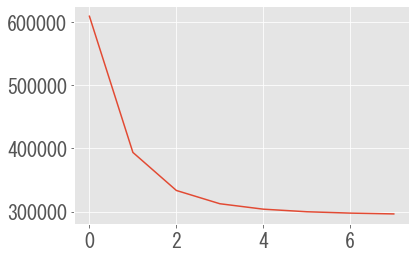

経過時間(実績)　= 0:12:56.430092 49902 / 50000 (99.80%)

lambda_p = 4.6415888336127775, alpha = 0.004281332398719396, r_purchase = 0.1
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:25.681105 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:00:49.531183 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:21.526083 4800002 / 4852467 (98.92%)

1134926.5393889712
======= t =  1 =========
update P
経過時間(実績)　= 0:01:25.577425 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:00:48.681768 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:21.829927 4800002 / 4852467 (98.92%)

715901.1064595605
======= t =  2 =========
update P
経過時間(実績)　= 0:01:25.846752 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:00:48.862519 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:21.418190 4800002 / 4852467 (98.92%)

643785.0526051683
======= t =  3 =========
update P
経過時間(実績)　= 0:01:25.311387 940002 / 950000 (98.95%)

update Q
経過時間(実績)　=

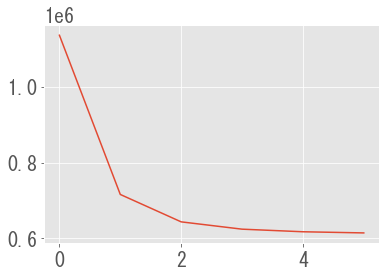

経過時間(実績)　= 0:17:29.530589 49902 / 50000 (99.80%)

lambda_p = 0.46415888336127775, alpha = 0.001, r_purchase = 0.1
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:59.119479 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:04.780712 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:27.949897 4800002 / 4852467 (98.92%)

151260.26007400238
======= t =  1 =========
update P
経過時間(実績)　= 0:01:55.625515 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:03.442957 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:28.908436 4800002 / 4852467 (98.92%)

120464.67955663147
======= t =  2 =========
update P
経過時間(実績)　= 0:01:52.118278 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:03.509944 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:27.583940 4800002 / 4852467 (98.92%)

102079.67459465384
======= t =  3 =========
update P
経過時間(実績)　= 0:01:53.299944 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:03.750

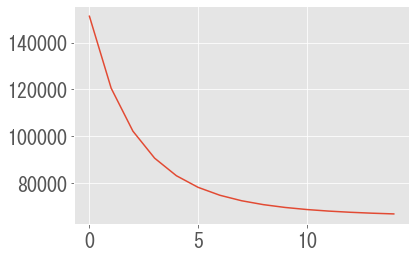

経過時間(実績)　= 0:16:21.451558 49902 / 50000 (99.80%)

lambda_p = 4.6415888336127775, alpha = 0.0379269019073225, r_purchase = 0.1
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:52.798377 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:03.679354 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:27.029421 4800002 / 4852467 (98.92%)

1137762.2133506073
======= t =  1 =========
update P
経過時間(実績)　= 0:01:53.056212 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:02.885808 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:27.249548 4800002 / 4852467 (98.92%)

717503.5407498546
======= t =  2 =========
update P
経過時間(実績)　= 0:01:52.266698 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:03.240915 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:27.281863 4800002 / 4852467 (98.92%)

644642.2209083273
======= t =  3 =========
update P
経過時間(実績)　= 0:01:52.360752 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0

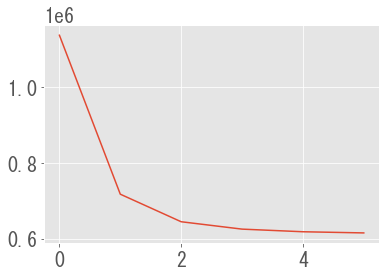

経過時間(実績)　= 0:16:45.816611 49902 / 50000 (99.80%)

lambda_p = 0.01, alpha = 0.012742749857031334, r_purchase = 0.1
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:58.170445 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:09.297548 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:27.966191 4800002 / 4852467 (98.92%)

3346.6788467327465
======= t =  1 =========
update P
経過時間(実績)　= 0:01:58.606408 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:07.022731 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:30.873520 4800002 / 4852467 (98.92%)

3318.8522982257387
======= t =  2 =========
update P
経過時間(実績)　= 0:01:58.436404 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:06.609394 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:28.861298 4800002 / 4852467 (98.92%)

3291.5882304901006
======= t =  3 =========
update P
経過時間(実績)　= 0:01:57.689831 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:07.071

経過時間(実績)　= 0:02:01.279626 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:07.324535 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:28.657240 4800002 / 4852467 (98.92%)

2640.7678718628017
======= t =  35 =========
update P
経過時間(実績)　= 0:02:01.695266 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:07.840305 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:27.797755 4800002 / 4852467 (98.92%)

2625.641721389285
======= t =  36 =========
update P
経過時間(実績)　= 0:01:57.475410 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:07.508990 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:28.674062 4800002 / 4852467 (98.92%)

2610.7550719562128
======= t =  37 =========
update P
経過時間(実績)　= 0:01:58.152831 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:07.551532 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:29.502729 4800002 / 4852467 (98.92%)

2596.102915457116
======= t =  38 =========
update P
経過時間(実績)　= 0:01:57.267306 940002 / 950000 (98.95%)

update Q
経過時間(

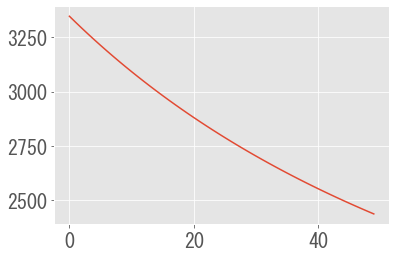

経過時間(実績)　= 0:17:19.317376 49902 / 50000 (99.80%)



In [44]:
num_sample_for_pre_GR = 5 # Gauss過程回帰の前に調べるサンプル数
num_iteration = 100
threshold_break = 0.005 # lossの改善が0.5%以下になったらbreak
k_dim = 100

model = matrix_factorization(df_R_train, df_item_features, k_dim, alpha = alpha_start, r_purchase = r_purchase_start, \
                             lambda_p = lambda_p_start, lambda_q = lambda_p_start)

model.update(60, threshold_break)

df_P_base = model.df_P.copy()
df_Q_base = model.df_Q.copy()

for idx_sample in range(num_sample_for_pre_GR):
    # 探索するべきパラメータを，まだ探索していないところから抽出
    idx_param_list_to_test = df_params[df_params["score"].isnull()].index.values
    idx_param_to_test = random.choice(idx_param_list_to_test)
    alpha, r_purchace, lambda_p = df_params.loc[idx_param_to_test].values[0:3] # scoreの列は除く
    print("lambda_p = {:0}, alpha = {:1}, r_purchase = {:2}".format(lambda_p, alpha, r_purchase))
    
    # 学習開始
    model.reset_params(alpha, r_purchase, lambda_p = lambda_p, lambda_q = lambda_p)
    model.df_P = df_P_base.copy()
    model.df_Q = df_Q_base.copy()
    loss_list = model.update(num_iteration, threshold_break)
    if len(loss_list) > 1:
        plt.plot(range(len(loss_list)), loss_list)
        plt.show()
    
    # スコアの算出
    df_y_pred = model.predict_items(df_X_valid, df_candidate_items)
    df_params.at[idx_param_to_test, "score"] = mean_reciprocal_rank(df_y_valid, df_y_pred)

`Gauss`過程回帰の準備

In [45]:
kernel = kernels.RBF(1.0, (3e-1, 1e3)) + kernels.ConstantKernel(1.0, (3e-1, 1e3)) + kernels.WhiteKernel()
model_hyper_param = GaussianProcessRegressor(
    kernel = kernel,
    alpha = 1e-5,
    optimizer = "fmin_l_bfgs_b",
    n_restarts_optimizer = 20,
    normalize_y = True)

実行しつつハイパーパラメータを探索

=======Gaussian Process Regression=======
idx_to_test = 1257
=======Implicit Matrix Factorizatioin=======
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:00.733356 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:00:44.561621 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:20.195620 4800002 / 4852467 (98.92%)

609013.6531005751
======= t =  1 =========
update P
経過時間(実績)　= 0:01:19.668952 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:00:49.197383 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:20.824064 4800002 / 4852467 (98.92%)

393543.5099828764
======= t =  2 =========
update P
経過時間(実績)　= 0:01:22.652734 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:00:48.221972 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:20.679854 4800002 / 4852467 (98.92%)

333392.1210335026
======= t =  3 =========
update P
経過時間(実績)　= 0:01:22.562951 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:00:47.591022 23002 /

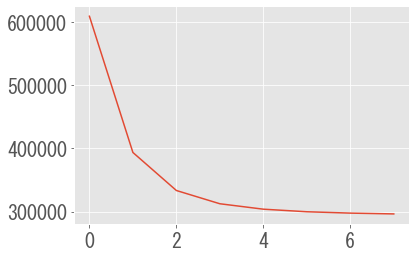

経過時間(実績)　= 0:12:57.921730 49902 / 50000 (99.80%)

=======Gaussian Process Regression=======
idx_to_test = 1447
=======Implicit Matrix Factorizatioin=======
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:24.825176 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:00:51.556779 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:21.598615 4800002 / 4852467 (98.92%)

609135.6236856014
======= t =  1 =========
update P
経過時間(実績)　= 0:01:24.671092 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:00:49.418932 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:21.158764 4800002 / 4852467 (98.92%)

393669.469134189
======= t =  2 =========
update P
経過時間(実績)　= 0:01:24.218434 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:00:48.977387 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:21.673179 4800002 / 4852467 (98.92%)

333469.120734419
======= t =  3 =========
update P
経過時間(実績)　= 0:01:23.228233 940002 / 950000 (98.

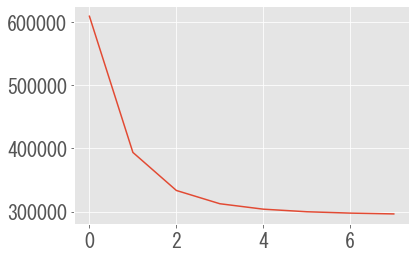

経過時間(実績)　= 0:12:45.491703 49902 / 50000 (99.80%)

=======Gaussian Process Regression=======
idx_to_test = 1456
=======Implicit Matrix Factorizatioin=======
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:22.299526 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:00:48.418248 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:20.986285 4800002 / 4852467 (98.92%)

310542.19991759426
======= t =  1 =========
update P
経過時間(実績)　= 0:01:22.516295 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:00:48.821756 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:20.696104 4800002 / 4852467 (98.92%)

220486.74593708338
======= t =  2 =========
update P
経過時間(実績)　= 0:01:22.422484 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:00:49.148585 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:20.509199 4800002 / 4852467 (98.92%)

181681.7578637183
======= t =  3 =========
update P
経過時間(実績)　= 0:01:23.073261 940002 / 950000 

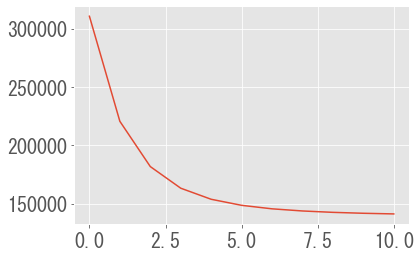

経過時間(実績)　= 0:15:22.709954 49902 / 50000 (99.80%)

=======Gaussian Process Regression=======
idx_to_test = 1446
=======Implicit Matrix Factorizatioin=======
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:44.817721 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:00.776050 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:25.463685 4800002 / 4852467 (98.92%)

310542.19991759426
======= t =  1 =========
update P
経過時間(実績)　= 0:01:44.064271 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:00.458717 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:24.648164 4800002 / 4852467 (98.92%)

220486.74593708338
======= t =  2 =========
update P
経過時間(実績)　= 0:01:40.894865 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:00:59.536228 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:24.312204 4800002 / 4852467 (98.92%)

181681.7578637183
======= t =  3 =========
update P
経過時間(実績)　= 0:01:41.941966 940002 / 950000 

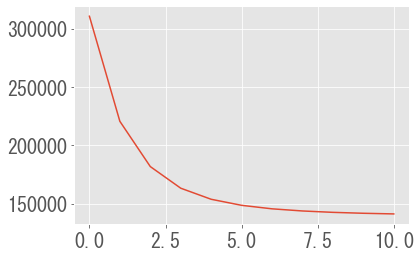

経過時間(実績)　= 0:14:44.321910 49902 / 50000 (99.80%)

=======Gaussian Process Regression=======
idx_to_test = 1646
=======Implicit Matrix Factorizatioin=======
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:39.316651 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:00:58.135864 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:24.304011 4800002 / 4852467 (98.92%)

310593.34071798075
======= t =  1 =========
update P
経過時間(実績)　= 0:01:38.649820 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:00:58.939422 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:24.039491 4800002 / 4852467 (98.92%)

220587.6447177894
======= t =  2 =========
update P
経過時間(実績)　= 0:01:38.773067 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:00:58.440314 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:23.563754 4800002 / 4852467 (98.92%)

181767.7871389733
======= t =  3 =========
update P
経過時間(実績)　= 0:01:38.452037 940002 / 950000 (

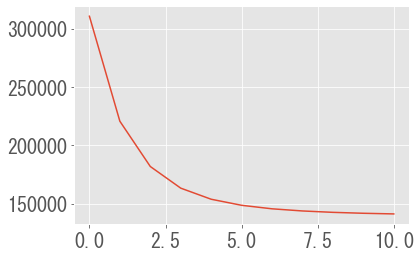

経過時間(実績)　= 0:14:59.105303 49902 / 50000 (99.80%)

=======Gaussian Process Regression=======
idx_to_test = 1256
=======Implicit Matrix Factorizatioin=======
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:43.481855 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:01.913181 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:24.437377 4800002 / 4852467 (98.92%)

310506.5248378954
======= t =  1 =========
update P
経過時間(実績)　= 0:01:43.768544 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:00.708805 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:24.100862 4800002 / 4852467 (98.92%)

220416.47578502455
======= t =  2 =========
update P
経過時間(実績)　= 0:01:40.396458 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:00:59.070178 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:24.179530 4800002 / 4852467 (98.92%)

181621.88860544105
======= t =  3 =========
update P
経過時間(実績)　= 0:01:40.429757 940002 / 950000 

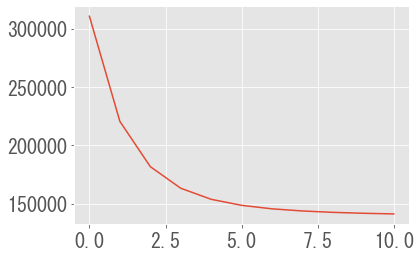

経過時間(実績)　= 0:14:54.206699 49902 / 50000 (99.80%)

=======Gaussian Process Regression=======
idx_to_test = 1056
=======Implicit Matrix Factorizatioin=======
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:41.272698 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:00:58.654762 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:23.964359 4800002 / 4852467 (98.92%)

310481.66438418714
======= t =  1 =========
update P
経過時間(実績)　= 0:01:41.678635 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:00:58.374013 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:24.101171 4800002 / 4852467 (98.92%)

220367.5634167468
======= t =  2 =========
update P
経過時間(実績)　= 0:01:39.121881 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:00:58.767481 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:24.511423 4800002 / 4852467 (98.92%)

181580.23777631886
======= t =  3 =========
update P
経過時間(実績)　= 0:01:40.743564 940002 / 950000 

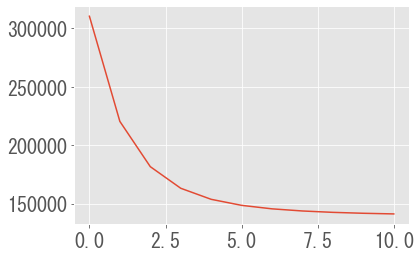

経過時間(実績)　= 0:14:48.891799 49902 / 50000 (99.80%)

=======Gaussian Process Regression=======
idx_to_test = 856
=======Implicit Matrix Factorizatioin=======
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:39.676085 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:00:59.185745 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:25.446999 4800002 / 4852467 (98.92%)

310464.3527834665
======= t =  1 =========
update P
経過時間(実績)　= 0:01:39.151075 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:00:58.683788 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:23.833249 4800002 / 4852467 (98.92%)

220333.53032894075
======= t =  2 =========
update P
経過時間(実績)　= 0:01:38.882029 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:00:59.112337 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:23.746304 4800002 / 4852467 (98.92%)

181551.2678376054
======= t =  3 =========
update P
経過時間(実績)　= 0:01:40.051040 940002 / 950000 (9

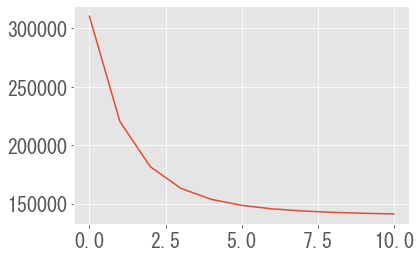

経過時間(実績)　= 0:14:53.225684 49902 / 50000 (99.80%)

=======Gaussian Process Regression=======
idx_to_test = 455
=======Implicit Matrix Factorizatioin=======
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:39.411535 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:07.033664 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:33.121780 4800002 / 4852467 (98.92%)

151262.40858624174
======= t =  1 =========
update P
経過時間(実績)　= 0:01:46.690447 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:00:58.736490 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:24.772100 4800002 / 4852467 (98.92%)

120472.82511671903
======= t =  2 =========
update P
経過時間(実績)　= 0:01:40.098090 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:00:59.114079 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:24.570130 4800002 / 4852467 (98.92%)

102089.16263103596
======= t =  3 =========
update P
経過時間(実績)　= 0:01:39.643871 940002 / 950000 

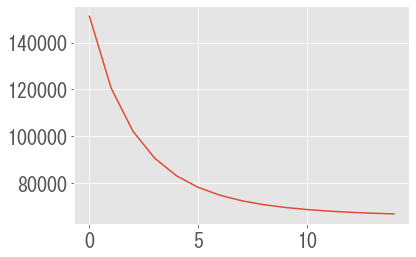

経過時間(実績)　= 0:13:58.910261 49902 / 50000 (99.80%)

=======Gaussian Process Regression=======
idx_to_test = 657
=======Implicit Matrix Factorizatioin=======
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:36.913890 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:00:57.798393 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:24.002985 4800002 / 4852467 (98.92%)

608828.4354667681
======= t =  1 =========
update P
経過時間(実績)　= 0:01:35.894084 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:00:57.723016 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:23.695693 4800002 / 4852467 (98.92%)

393352.52507492836
======= t =  2 =========
update P
経過時間(実績)　= 0:01:38.335332 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:00:57.775110 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:23.897437 4800002 / 4852467 (98.92%)

333275.441331911
======= t =  3 =========
update P
経過時間(実績)　= 0:01:36.800378 940002 / 950000 (98

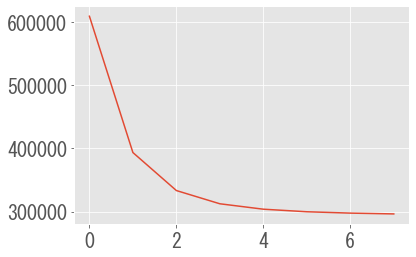

経過時間(実績)　= 0:14:37.062962 49902 / 50000 (99.80%)

=======Gaussian Process Regression=======
idx_to_test = 1246
=======Implicit Matrix Factorizatioin=======
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:37.357046 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:00:56.993983 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:23.383798 4800002 / 4852467 (98.92%)

310506.5248378954
======= t =  1 =========
update P
経過時間(実績)　= 0:01:37.586439 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:00:56.961218 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:24.048309 4800002 / 4852467 (98.92%)

220416.47578502455
======= t =  2 =========
update P
経過時間(実績)　= 0:01:36.463550 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:00:57.911213 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:24.068935 4800002 / 4852467 (98.92%)

181621.88860544105
======= t =  3 =========
update P
経過時間(実績)　= 0:01:36.886388 940002 / 950000 

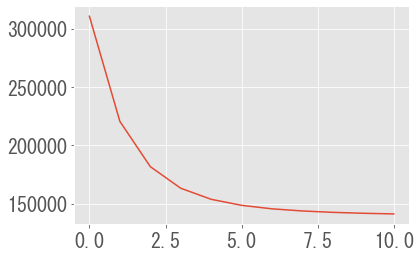

経過時間(実績)　= 0:14:45.625164 49902 / 50000 (99.80%)

=======Gaussian Process Regression=======
idx_to_test = 1046
=======Implicit Matrix Factorizatioin=======
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:41.044243 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:00:59.612879 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:24.274428 4800002 / 4852467 (98.92%)

310481.66438418714
======= t =  1 =========
update P
経過時間(実績)　= 0:01:40.353910 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:42.651904 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:30.919252 4800002 / 4852467 (98.92%)

220367.5634167468
======= t =  2 =========
update P
経過時間(実績)　= 0:01:36.391483 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:00:50.543024 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:21.257332 4800002 / 4852467 (98.92%)

181580.23777631886
======= t =  3 =========
update P
経過時間(実績)　= 0:01:25.097695 940002 / 950000 

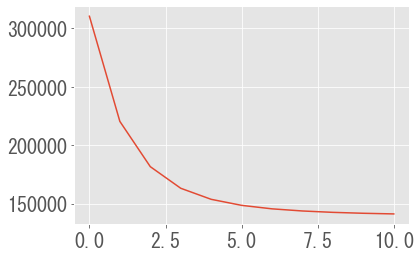

経過時間(実績)　= 0:12:44.246148 49902 / 50000 (99.80%)

=======Gaussian Process Regression=======
idx_to_test = 846
=======Implicit Matrix Factorizatioin=======
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:23.848920 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:00:49.516251 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:21.471459 4800002 / 4852467 (98.92%)

310464.3527834665
======= t =  1 =========
update P
経過時間(実績)　= 0:01:22.404730 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:00:48.481842 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:20.898125 4800002 / 4852467 (98.92%)

220333.53032894075
======= t =  2 =========
update P
経過時間(実績)　= 0:01:21.468722 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:00:48.436080 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:20.823306 4800002 / 4852467 (98.92%)

181551.2678376054
======= t =  3 =========
update P
経過時間(実績)　= 0:01:21.596256 940002 / 950000 (9

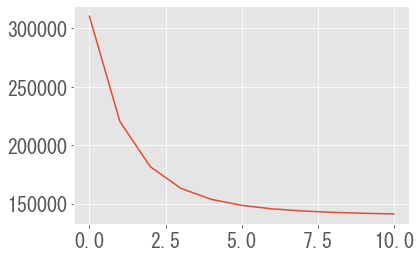

経過時間(実績)　= 0:15:37.744263 49902 / 50000 (99.80%)

=======Gaussian Process Regression=======
idx_to_test = 646
=======Implicit Matrix Factorizatioin=======
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:44.893842 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:00:59.946835 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:25.074310 4800002 / 4852467 (98.92%)

310452.30393882375
======= t =  1 =========
update P
経過時間(実績)　= 0:01:41.855630 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:00.100402 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:24.965882 4800002 / 4852467 (98.92%)

220309.85646792877
======= t =  2 =========
update P
経過時間(実績)　= 0:01:42.135035 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:00:58.919375 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:24.270611 4800002 / 4852467 (98.92%)

181531.12109386784
======= t =  3 =========
update P
経過時間(実績)　= 0:01:40.292879 940002 / 950000 

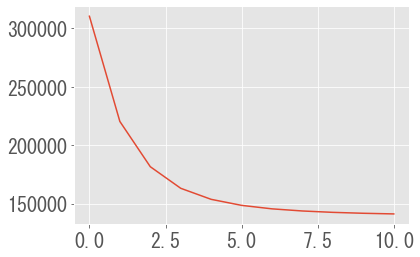

経過時間(実績)　= 0:15:06.816922 49902 / 50000 (99.80%)

=======Gaussian Process Regression=======
idx_to_test = 446
=======Implicit Matrix Factorizatioin=======
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:43.829476 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:00.662256 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:25.882323 4800002 / 4852467 (98.92%)

310443.92091961176
======= t =  1 =========
update P
経過時間(実績)　= 0:01:44.842028 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:00.213784 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:25.697202 4800002 / 4852467 (98.92%)

220293.39165177144
======= t =  2 =========
update P
経過時間(実績)　= 0:01:43.286815 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:00.596197 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:25.979884 4800002 / 4852467 (98.92%)

181517.1118139561
======= t =  3 =========
update P
経過時間(実績)　= 0:01:44.365606 940002 / 950000 (

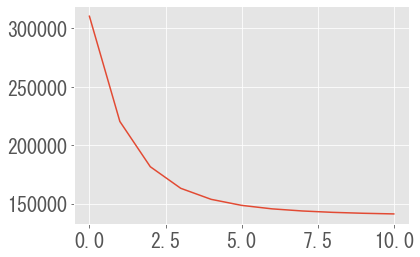

経過時間(実績)　= 0:15:27.414099 49902 / 50000 (99.80%)

=======Gaussian Process Regression=======
idx_to_test = 246
=======Implicit Matrix Factorizatioin=======
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:44.366444 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:01.050192 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:24.786811 4800002 / 4852467 (98.92%)

310438.0898399198
======= t =  1 =========
update P
経過時間(実績)　= 0:01:45.439888 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:00.678886 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:24.778323 4800002 / 4852467 (98.92%)

220281.94208473465
======= t =  2 =========
update P
経過時間(実績)　= 0:01:45.805752 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:00.922577 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:25.117696 4800002 / 4852467 (98.92%)

181507.3710157843
======= t =  3 =========
update P
経過時間(実績)　= 0:01:45.214551 940002 / 950000 (9

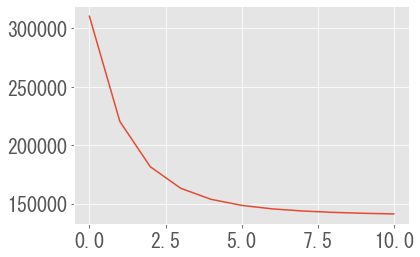

経過時間(実績)　= 0:15:56.776272 49902 / 50000 (99.80%)

=======Gaussian Process Regression=======


C:\Users\yota-\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


idx_to_test = 656
=======Implicit Matrix Factorizatioin=======
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:51.244528 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:02.387437 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:26.457310 4800002 / 4852467 (98.92%)

310452.30393882375
======= t =  1 =========
update P
経過時間(実績)　= 0:01:49.727531 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:03.307616 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:27.169895 4800002 / 4852467 (98.92%)

220309.85646792877
======= t =  2 =========
update P
経過時間(実績)　= 0:01:49.719838 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:02.256598 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:26.433090 4800002 / 4852467 (98.92%)

181531.12109386784
======= t =  3 =========
update P
経過時間(実績)　= 0:01:49.851293 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:02.304146 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)

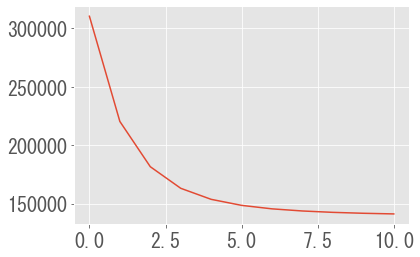

経過時間(実績)　= 0:15:53.080940 49902 / 50000 (99.80%)

=======Gaussian Process Regression=======
idx_to_test = 456
=======Implicit Matrix Factorizatioin=======
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:49.668147 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:02.700724 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:27.009428 4800002 / 4852467 (98.92%)

310443.92091961176
======= t =  1 =========
update P
経過時間(実績)　= 0:01:49.557437 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:03.232214 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:26.748796 4800002 / 4852467 (98.92%)

220293.39165177144
======= t =  2 =========
update P
経過時間(実績)　= 0:01:49.158848 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:02.746081 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:27.191346 4800002 / 4852467 (98.92%)

181517.1118139561
======= t =  3 =========
update P
経過時間(実績)　= 0:01:49.401069 940002 / 950000 (

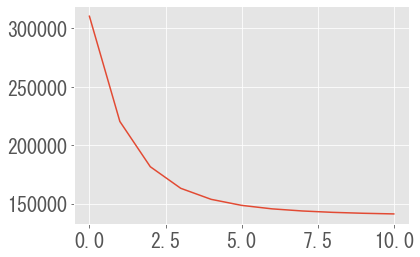

経過時間(実績)　= 0:15:57.713983 49902 / 50000 (99.80%)

=======Gaussian Process Regression=======
idx_to_test = 256
=======Implicit Matrix Factorizatioin=======
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:48.984363 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:02.461679 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:26.197234 4800002 / 4852467 (98.92%)

310438.0898399198
======= t =  1 =========
update P
経過時間(実績)　= 0:01:49.554038 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:02.410509 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:26.222143 4800002 / 4852467 (98.92%)

220281.94208473465
======= t =  2 =========
update P
経過時間(実績)　= 0:01:50.265771 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:02.670316 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:26.664183 4800002 / 4852467 (98.92%)

181507.3710157843
======= t =  3 =========
update P
経過時間(実績)　= 0:01:49.553655 940002 / 950000 (9

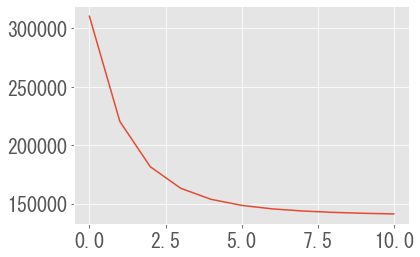

経過時間(実績)　= 0:16:38.238832 49902 / 50000 (99.80%)

=======Gaussian Process Regression=======
idx_to_test = 57
=======Implicit Matrix Factorizatioin=======
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:56.875186 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:05.895355 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:28.134970 4800002 / 4852467 (98.92%)

608766.070891627
======= t =  1 =========
update P
経過時間(実績)　= 0:01:59.099189 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:04.418324 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:27.331353 4800002 / 4852467 (98.92%)

393288.2970075664
======= t =  2 =========
update P
経過時間(実績)　= 0:01:52.960874 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:03.770697 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:27.004788 4800002 / 4852467 (98.92%)

333236.22114691517
======= t =  3 =========
update P
経過時間(実績)　= 0:01:52.910747 940002 / 950000 (98.

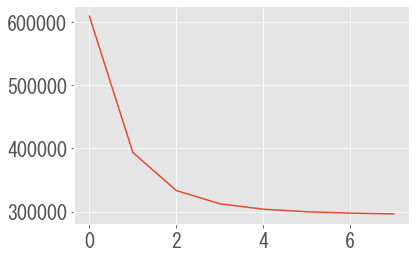

経過時間(実績)　= 0:15:56.782509 49902 / 50000 (99.80%)

=======Gaussian Process Regression=======


C:\Users\yota-\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


idx_to_test = 56
=======Implicit Matrix Factorizatioin=======
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:47.205601 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:01.658121 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:26.129090 4800002 / 4852467 (98.92%)

310434.0345362468
======= t =  1 =========
update P
経過時間(実績)　= 0:01:46.337843 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:02.238988 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:26.133951 4800002 / 4852467 (98.92%)

220273.98081065167
======= t =  2 =========
update P
経過時間(実績)　= 0:01:44.891438 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:00.534094 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:25.486180 4800002 / 4852467 (98.92%)

181500.59848636747
======= t =  3 =========
update P
経過時間(実績)　= 0:01:43.141993 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:00.411864 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　=

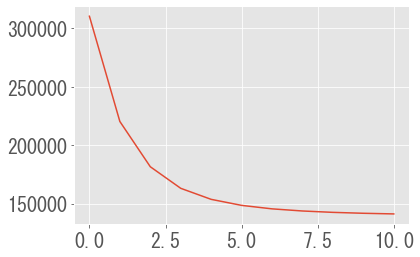

経過時間(実績)　= 0:16:22.199873 49902 / 50000 (99.80%)

=======Gaussian Process Regression=======


C:\Users\yota-\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


idx_to_test = 46
=======Implicit Matrix Factorizatioin=======
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:52.852322 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:03.639355 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:29.252074 4800002 / 4852467 (98.92%)

310434.0345362468
======= t =  1 =========
update P
経過時間(実績)　= 0:01:51.691887 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:03.873329 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:27.424531 4800002 / 4852467 (98.92%)

220273.98081065167
======= t =  2 =========
update P
経過時間(実績)　= 0:01:52.575344 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:03.828127 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:27.567223 4800002 / 4852467 (98.92%)

181500.59848636747
======= t =  3 =========
update P
経過時間(実績)　= 0:01:51.821250 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:04.132180 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　=

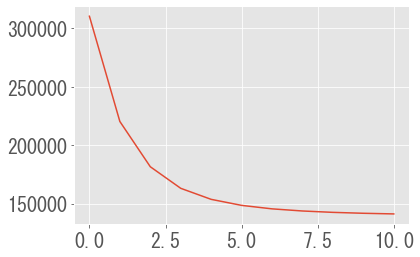

経過時間(実績)　= 0:16:49.277943 49902 / 50000 (99.80%)

=======Gaussian Process Regression=======
idx_to_test = 1846
=======Implicit Matrix Factorizatioin=======
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:57.961061 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:06.989374 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:30.450990 4800002 / 4852467 (98.92%)

310666.5422683929
======= t =  1 =========
update P
経過時間(実績)　= 0:01:58.124709 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:07.004244 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:29.045829 4800002 / 4852467 (98.92%)

220732.4087008199
======= t =  2 =========
update P
経過時間(実績)　= 0:02:00.872699 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:06.583741 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:28.780875 4800002 / 4852467 (98.92%)

181891.35071019607
======= t =  3 =========
update P
経過時間(実績)　= 0:01:58.431342 940002 / 950000 (

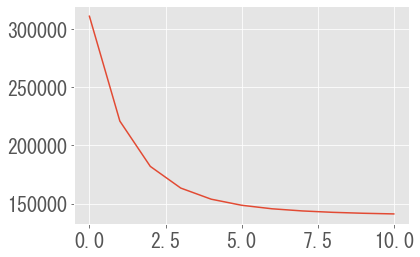

経過時間(実績)　= 0:17:01.005646 49902 / 50000 (99.80%)

=======Gaussian Process Regression=======
idx_to_test = 1656
=======Implicit Matrix Factorizatioin=======
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:58.288061 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:07.000120 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:28.665203 4800002 / 4852467 (98.92%)

310593.34071798075
======= t =  1 =========
update P
経過時間(実績)　= 0:01:56.521192 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:09.792384 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:29.491819 4800002 / 4852467 (98.92%)

220587.6447177894
======= t =  2 =========
update P
経過時間(実績)　= 0:01:58.384305 940002 / 950000 (98.95%)

update Q
経過時間(実績)　= 0:01:08.750236 23002 / 23511 (97.83%)

calculate loss
経過時間(実績)　= 0:00:28.388271 4800002 / 4852467 (98.92%)

181767.7871389733
======= t =  3 =========
update P
経過時間(実績)　= 0:02:01.700676 940002 / 950000 (

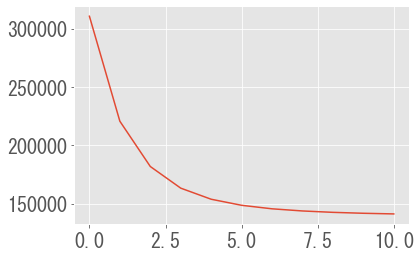

経過時間(実績)　= 0:16:35.776800 49902 / 50000 (99.80%)



In [55]:
num_sample_for_GR = 24

for idx_sample in range(num_sample_for_GR):
    print("idx_sample = {:}".format(idx_sample), end = "\r")
    # Gauss過程回帰で探索するべきパラメータを調べる
    ## Gauss過程回帰の学習
    print("=======Gaussian Process Regression=======")
    data_train_i = df_params[~(df_params["score"].isnull())].copy() # スコアが分かっているサンプルを抽出
    x_train_i = np.log(data_train_i[["lambda_p", "alpha", "r_purchase"]].values) # 入力値的にlogスケールがよさそう
    y_train_i = data_train_i[["score"]].values
    model_hyper_param.fit(x_train_i, y_train_i) # 学習
    ## Gauss過程回帰による予測
    data_test_i = df_params[df_params["score"].isnull()].copy() # スコアがわかっていないサンプルを抽出
    x_test_i = np.log(data_test_i[["lambda_p", "alpha", "r_purchase"]].values)
    pred_test, std_test = model_hyper_param.predict(x_test_i, return_std = True)
    pred_test = pred_test[:, 0] # pred_testの形が(n, 1)のような"行列"なのでベクトルに直す(std_testはそのようになっていない(?))
    ## ハイパーパラメータを探索 
    upper_confidence_bound = pred_test + np.sqrt(np.log(len(pred_test)) / len(pred_test)) * std_test # 獲得関数はUpper Confidence Bound
    data_test_i["UCB"] = upper_confidence_bound
    idx_to_test = data_test_i.sort_values(by = "UCB", ascending = False).index.values[0] # 獲得関数を最大化するパラメータ(のインデックス)
    print("idx_to_test = {:}".format(idx_to_test))

    # 学習開始
    print("=======Implicit Matrix Factorizatioin=======")
    alpha, r_purchace, lambda_p = df_params.loc[idx_to_test].values[0:3] # scoreの列は除く

    model.reset_params(alpha, r_purchase, lambda_p = lambda_p, lambda_q = lambda_p)
    model.df_P = df_P_base.copy()
    model.df_Q = df_Q_base.copy()
    loss_list = model.update(num_iteration, threshold_break)
    if len(loss_list) > 1:
        plt.plot(range(len(loss_list)), loss_list)
        plt.show()

    # スコアの算出
    df_y_pred = model.predict_items(df_X_valid, df_candidate_items)
    df_params.at[idx_to_test, "score"] = mean_reciprocal_rank(df_y_valid, df_y_pred)
    


In [57]:
df_params.sort_values("score", ascending = False).head(20)

,alpha,r_purchase,lambda_p,score
246,0.001438,0.069519,1.000000,0.041326
256,0.001438,0.112884,1.000000,0.041326
46,0.001000,0.069519,1.000000,0.041326
56,0.001000,0.112884,1.000000,0.041326
446,0.002069,0.069519,1.000000,0.041324
456,0.002069,0.112884,1.000000,0.041324
646,0.002976,0.069519,1.000000,0.041311
656,0.002976,0.112884,1.000000,0.041311
846,0.004281,0.069519,1.000000,0.041305
856,0.004281,0.112884,1.000000,0.041305


In [54]:
df_params.loc[1257]

alpha         0.008859
r_purchase    0.112884
lambda_p      2.154435
score              NaN
Name: 1257, dtype: float64

In [59]:
df_param.sort_values(by = "score", ascending = False)

NameError: name 'df_param' is not defined

In [52]:
data_test_i.sort_values(by = "UCB", ascending = False)

,alpha,r_purchase,lambda_p,score,UCB
1257,0.008859,0.112884,2.154435,NaN,0.040689
1657,0.018330,0.112884,2.154435,NaN,0.040689
1760,0.018330,23.357215,0.010000,NaN,0.040687
1360,0.008859,23.357215,0.010000,NaN,0.040687
1447,0.012743,0.069519,2.154435,NaN,0.040541
...,...,...,...,...,...
1878,0.026367,0.297635,4.641589,NaN,0.040126
2278,0.054556,0.297635,4.641589,NaN,0.040126
608,0.002976,0.010000,4.641589,NaN,0.040114
1008,0.006158,0.010000,4.641589,NaN,0.040114


In [50]:
df_params[~(df_params["score"].isnull())]

,alpha,r_purchase,lambda_p,score
155,0.001000,14.384499,0.464159,0.039738
808,0.004281,0.010000,4.641589,0.039774
1457,0.012743,0.112884,2.154435,0.041128
1560,0.012743,23.357215,0.010000,0.041122
2078,0.037927,0.297635,4.641589,0.039803


In [29]:
idx_sample = 0
print("idx_sample = {:}".format(idx_sample), end = "\r")
# Gauss過程回帰で探索するべきパラメータを調べる
## Gauss過程回帰の学習
print("=======Gaussian Process Regression=======")
data_train_i = df_params[~(df_params["score"].isnull())].copy() # スコアが分かっているサンプルを抽出
x_train_i = np.log(data_train_i[["lambda_p", "alpha", "r_purchase"]].values) # 入力値的にlogスケールがよさそう
y_train_i = data_train_i[["score"]].values
model_hyper_param.fit(x_train_i, y_train_i) # 学習
## Gauss過程回帰による予測
data_test_i = df_params[df_params["score"].isnull()].copy() # スコアがわかっていないサンプルを抽出
x_test_i = np.log(data_test_i[["lambda_p", "alpha", "r_purchase"]].values)
pred_test, std_test = model_hyper_param.predict(x_test_i, return_std = True)
pred_test = pred_test[:, 0] # pred_testの形が(n, 1)のような"行列"なのでベクトルに直す(std_testはそのようになっていない(?))
## ハイパーパラメータを探索 
upper_confidence_bound = pred_test + np.sqrt(np.log(len(pred_test)) / len(pred_test)) * std_test # 獲得関数はUpper Confidence Bound
data_test_i["UCB"] = upper_confidence_bound
idx_to_test = data_test_i.sort_values(by = "UCB", ascending = False).index.values[0] # 獲得関数を最大化するパラメータ(のインデックス)
print("idx_to_test = {:}".format(idx_to_test))

# 学習開始
print("=======Implicit Matrix Factorizatioin=======")
alpha, r_purchace, lambda_p = df_params.loc[idx_to_test].values[0:3] # scoreの列は除く

model.reset_params(alpha, r_purchase, lambda_p = lambda_p, lambda_q = lambda_p)
model.df_P = df_P_base.copy()
model.df_Q = df_Q_base.copy()
loss_list = model.update(num_iteration, threshold_break)
if len(loss_list) > 1:
    plt.plot(range(len(loss_list)), loss_list)
    plt.show()

# スコアの算出
df_y_pred = model.predict_items(df_X_valid, df_candidate_items)
df_params.at[idx_param_to_test, "score"] = mean_reciprocal_rank(df_y_valid, df_y_pred)

=======Gaussian Process Regression=======
=======Implicit Matrix Factorizatioin=======
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:39.643668 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:00:57.493017 23002 / 23596 (97.48%)

calculate loss
経過時間(実績)　= 0:00:24.178254 5000002 / 5056931 (98.87%)

3063819.4326988957
経過時間(実績)　= 0:02:59.284517 9902 / 10000 (99.01%)



In [28]:
model = matrix_factorization(df_R_train, df_item_features, k_dim, alpha = alpha_start, r_purchase = r_purchase_start, \
                             lambda_p = lambda_p_start, lambda_q = lambda_p_start)

model.update(1, threshold_break)

sessionとitemの変換辞書作成開始
処理1完了：session -> item
処理2完了：item -> session
処理3完了：session -> eval
処理4完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:26.370293 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:09.209810 23002 / 23596 (97.48%)

calculate loss
経過時間(実績)　= 0:00:25.649361 5000002 / 5056931 (98.87%)

10032.483059359887


[10032.483059359887]

In [ ]:
for i in range(num_iteration2):
    print("i = {:}".format(i))
    data_train_i = df_params[~(df_params["score"].isnull())].copy()
    x_train_i = np.log(data_train_i[["lambda_p", "alpha", "r_purchase"]].values)
    y_train_i = data_train_i[["score"]].values
    
    model.fit(x_train_i, y_train_i)
    
    data_test_i = df_params[df_params["score"].isnull()].copy()
    x_test_i = np.log(data_test_i[["lambda_p", "alpha", "r_purchase"]].values)
    pred_test, std_test = model.predict(x_test_i, return_std = True)
    pred_test = pred_test[:, 0]
    upper_confidence_bound = pred_test + np.sqrt(np.log(len(pred_test)) / len(pred_test)) * std_test
    data_test_i["UCB"] = upper_confidence_bound
    idx_to_test = data_test_i.sort_values(by = "UCB", ascending = False).index.values[0]
    
    
    
    

sessionとitemの変換辞書作成開始
処理1完了：session -> item
処理2完了：item -> session
処理3完了：session -> eval
処理4完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:21.073911 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:11.893275 23002 / 23596 (97.48%)

calculate loss
経過時間(実績)　= 0:00:33.959975 5000002 / 5056931 (98.87%)

10025.241984495033
======= t =  1 =========
update P
経過時間(実績)　= 0:01:48.686709 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:09.368041 23002 / 23596 (97.48%)

calculate loss
経過時間(実績)　= 0:00:26.667999 5000002 / 5056931 (98.87%)

9110.676784107134
======= t =  2 =========
update P
経過時間(実績)　= 0:01:43.704385 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:10.914729 23002 / 23596 (97.48%)

calculate loss
経過時間(実績)　= 0:00:26.487006 5000002 / 5056931 (98.87%)

8568.043058063264
======= t =  3 =========
update P
経過時間(実績)　= 0:01:51.154081 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:07.584082 23002 / 23596 (97.48%)

calculate loss
経過時間(実績)　= 0:00:25.598316 5000002 / 

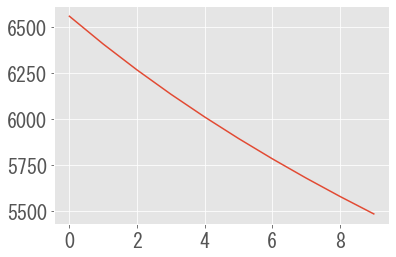

経過時間(実績)　= 0:04:13.204591 9902 / 10000 (99.01%)

score =  0.0010916076111003668
lambda_p = 0.01, alpha = 0.001, r_purchase = 0.1
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:59.830726 980002 / 990000 (98.99%)

update Q


KeyboardInterrupt: 

In [14]:
num_iteration = 1
threshold_break = 0.005 # lossの改善が0.5%以下になったらbreak
k_dim = 100

model = matrix_factorization(df_R_train, df_item_features, k_dim, alpha = alpha_start, r_purchase = r_purchase_start, \
                             lambda_p = lambda_p_start, lambda_q = lambda_p_start)

# path_data_temp = r'C:\Users\yota-\Desktop\study\mystudy\recsys\dressipi_recsys2022\data\temp'
# model.df_P = pd.read_pickle(path_data_temp + r'\df_P_IMF_k' + str(k_dim) + r'.pkl')
# model.df_Q = pd.read_pickle(path_data_temp + r'\df_Q_IMF_k' + str(k_dim) + r'.pkl')
# model.df_P = df_P_rec
# model.df_Q = df_Q_rec
model.update(10, threshold_break)

score_list_list = []

df_score = pd.DataFrame(columns = ["lambda_p", "alpha", "r_purchase", "score"])
idx_param = 0

for lambda_p in lambda_p_list:
    for alpha in alpha_list:
        for r_purchase in r_purchase_list:
            print("lambda_p = {:0}, alpha = {:1}, r_purchase = {:2}".format(lambda_p, alpha, r_purchase))
            model.reset_params(alpha, r_purchase, lambda_p = lambda_p, lambda_q = lambda_p)

            loss_list = model.update(num_iteration, threshold_break)
            if len(loss_list) > 1:
                plt.plot(range(len(loss_list)), loss_list)
                plt.show()

            # スコアの算出
            df_y_pred = model.predict_items(df_X_valid, df_candidate_items)
            score = mean_reciprocal_rank(df_y_valid, df_y_pred)
            
            df_score.loc[idx_param] = [lambda_p, alpha, r_purchase, score]
            print("score = ", score)
            idx_param += 1

各ハイパーパラメータについて，スコアをざっくり確認する．

0.01
0.1
1.0
10.0


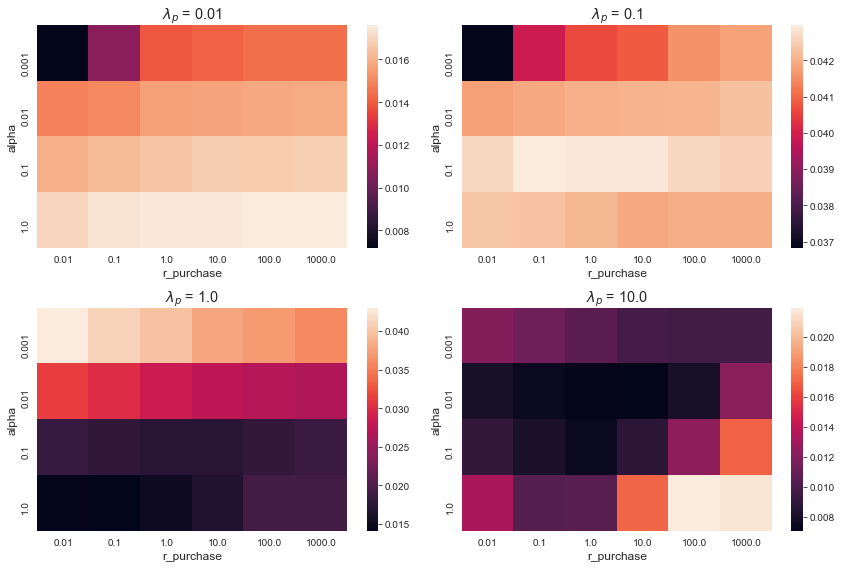

In [56]:
fig = plt.figure(figsize = (12, 8))


for idx, lambda_p in enumerate(df_score["lambda_p"].unique()):
    plt.subplot(2, 2, idx + 1)
    print(lambda_p)
    plt.title("$\lambda_p$ = {:}".format(lambda_p))
    sns.heatmap(df_score[df_score["lambda_p"] == lambda_p].pivot(index = "alpha", columns = "r_purchase", values = "score"), )
plt.tight_layout()
plt.show()
    

数値をより細かくしてグリッドサーチ

In [58]:
alpha_start = 0.001
alpha_end = 1.0
alpha_num = 4
alpha_list = np.geomspace(alpha_start, alpha_end, alpha_num)

r_purchase_start = 0.01
r_purchase_end = 100.0
r_purchase_num = 6
r_purchase_list = np.geomspace(r_purchase_start, r_purchase_end, r_purchase_num)

lambda_p_start = 0.05
lambda_p_end = 1.0
lambda_p_num = 4
lambda_p_list = np.geomspace(lambda_p_start, lambda_p_end, lambda_p_num)
print(alpha_list)
print(r_purchase_list)
print(lambda_p_list)

[0.001 0.01  0.1   1.   ]
[1.00000000e-02 6.30957344e-02 3.98107171e-01 2.51188643e+00
 1.58489319e+01 1.00000000e+02]
[0.05       0.13572088 0.36840315 1.        ]


======= t =  0 =========
update P
経過時間(実績)　= 0:00:58.540345 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:00:51.147331 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:29.628851 5000002 / 5057824 (98.86%)

[1407451.2009795394]
lambda_p = 0.049999999999999996, alpha = 0.001, r_purchase = 0.01
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:02:05.546243 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:14.303070 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:31.904103 5000002 / 5057824 (98.86%)

[7127.506706434769]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:29.813208 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:00:59.464199 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:22.850261 5000002 / 5057824 (98.86%)

[7127.506706434769, 7110.294681973893]


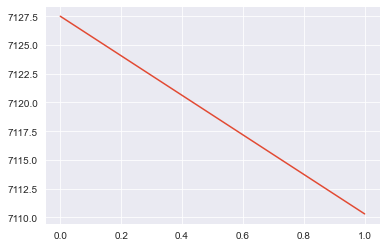

経過時間(実績)　= 0:02:29.140553 9902 / 10000 (99.01%)

score =  0.022100316075379267
lambda_p = 0.049999999999999996, alpha = 0.001, r_purchase = 0.06309573444801933
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:30.649875 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.613901 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.851902 5000002 / 5057824 (98.86%)

[7100.122217992751]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:33.250801 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:03.733717 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:22.728096 5000002 / 5057824 (98.86%)

[7100.122217992751, 7092.536241617555]


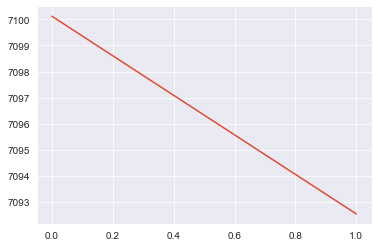

経過時間(実績)　= 0:02:37.334447 9902 / 10000 (99.01%)

score =  0.023824949132640664
lambda_p = 0.049999999999999996, alpha = 0.001, r_purchase = 0.3981071705534973
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:22.980625 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:00.762223 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.339750 5000002 / 5057824 (98.86%)

[7086.2329632850815]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:22.377597 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:00.322896 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.121657 5000002 / 5057824 (98.86%)

[7086.2329632850815, 7078.056125013828]


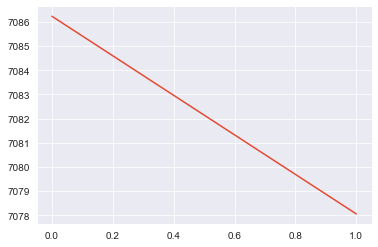

経過時間(実績)　= 0:02:35.428576 9902 / 10000 (99.01%)

score =  0.02566059100063022
lambda_p = 0.049999999999999996, alpha = 0.001, r_purchase = 2.5118864315095824
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:24.554946 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:02.672267 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.748635 5000002 / 5057824 (98.86%)

[7073.364811396923]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:24.744245 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:01.960631 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.274414 5000002 / 5057824 (98.86%)

[7073.364811396923, 7069.134613034087]


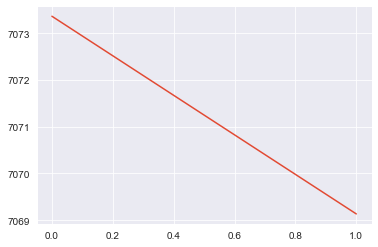

経過時間(実績)　= 0:02:39.971616 9902 / 10000 (99.01%)

score =  0.02700492032599873
lambda_p = 0.049999999999999996, alpha = 0.001, r_purchase = 15.848931924611142
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:24.833885 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:01.694145 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.656405 5000002 / 5057824 (98.86%)

[7065.474047265909]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:25.217214 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:01.662556 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.191377 5000002 / 5057824 (98.86%)

[7065.474047265909, 7061.971383055508]


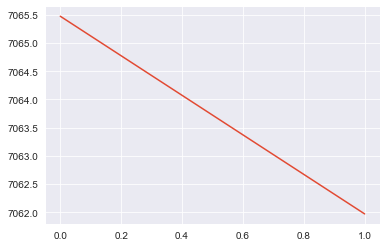

経過時間(実績)　= 0:02:39.094454 9902 / 10000 (99.01%)

score =  0.028839616284388064
lambda_p = 0.049999999999999996, alpha = 0.001, r_purchase = 100.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:25.532607 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:01.617546 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.576562 5000002 / 5057824 (98.86%)

[7050.60768408917]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:24.748920 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:01.944094 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.116684 5000002 / 5057824 (98.86%)

[7050.60768408917, 7047.284800405349]


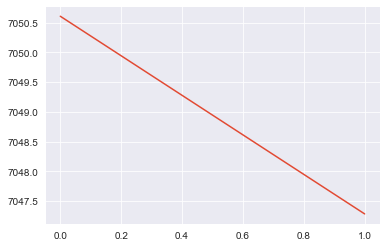

経過時間(実績)　= 0:02:42.923037 9902 / 10000 (99.01%)

score =  0.029681597675716553
lambda_p = 0.049999999999999996, alpha = 0.01, r_purchase = 0.01
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:29.422257 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:03.730928 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.224721 5000002 / 5057824 (98.86%)

[7043.774996953474]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:28.077883 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:04.219499 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.064593 5000002 / 5057824 (98.86%)

[7043.774996953474, 7041.102387810144]


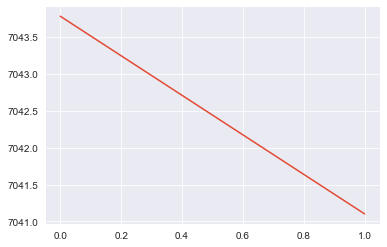

経過時間(実績)　= 0:02:44.741377 9902 / 10000 (99.01%)

score =  0.030487493769218717
lambda_p = 0.049999999999999996, alpha = 0.01, r_purchase = 0.06309573444801933
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:28.902893 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:03.003769 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.730913 5000002 / 5057824 (98.86%)

[7038.636953720621]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:28.157968 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:03.128630 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.986807 5000002 / 5057824 (98.86%)

[7038.636953720621, 7036.345210610829]


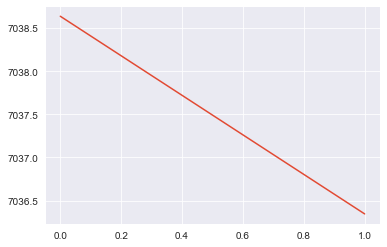

経過時間(実績)　= 0:02:42.880774 9902 / 10000 (99.01%)

score =  0.031058692906255077
lambda_p = 0.049999999999999996, alpha = 0.01, r_purchase = 0.3981071705534973
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:26.871104 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:02.774324 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.918399 5000002 / 5057824 (98.86%)

[7034.230231536642]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:13.405541 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:02.632341 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.255397 5000002 / 5057824 (98.86%)

[7034.230231536642, 7032.234213406293]


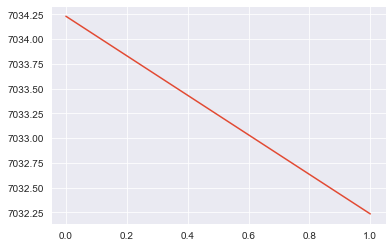

経過時間(実績)　= 0:02:58.793357 9902 / 10000 (99.01%)

score =  0.031841599308013606
lambda_p = 0.049999999999999996, alpha = 0.01, r_purchase = 2.5118864315095824
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:32.801070 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:10.425056 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.867420 5000002 / 5057824 (98.86%)

[7030.489288831276]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:32.458982 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:09.719945 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.320466 5000002 / 5057824 (98.86%)

[7030.489288831276, 7028.741008798222]


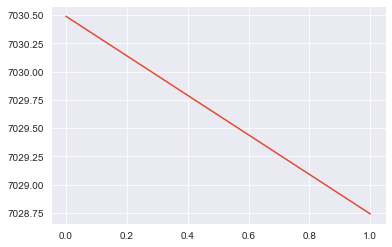

経過時間(実績)　= 0:03:00.798335 9902 / 10000 (99.01%)

score =  0.0323123365311611
lambda_p = 0.049999999999999996, alpha = 0.01, r_purchase = 15.848931924611142
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:31.859910 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:09.655600 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.815825 5000002 / 5057824 (98.86%)

[7027.781936453565]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:33.037021 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:10.715692 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.237392 5000002 / 5057824 (98.86%)

[7027.781936453565, 7026.277651115412]


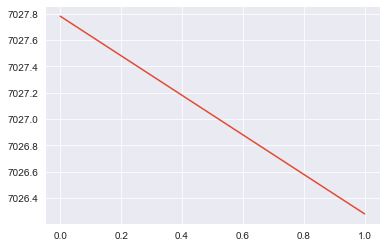

経過時間(実績)　= 0:02:58.276651 9902 / 10000 (99.01%)

score =  0.03249669056389395
lambda_p = 0.049999999999999996, alpha = 0.01, r_purchase = 100.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:31.277943 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:08.295739 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.358673 5000002 / 5057824 (98.86%)

[7027.36298506199]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:30.276614 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:08.389133 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.341423 5000002 / 5057824 (98.86%)

[7027.36298506199, 7026.18486228236]


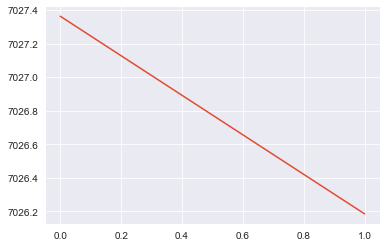

経過時間(実績)　= 0:02:54.978654 9902 / 10000 (99.01%)

score =  0.03255643387735732
lambda_p = 0.049999999999999996, alpha = 0.1, r_purchase = 0.01
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:31.594895 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:07.755921 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.501437 5000002 / 5057824 (98.86%)

[7022.32328456907]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:30.300847 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:08.139986 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.455160 5000002 / 5057824 (98.86%)

[7022.32328456907, 7021.129520663883]


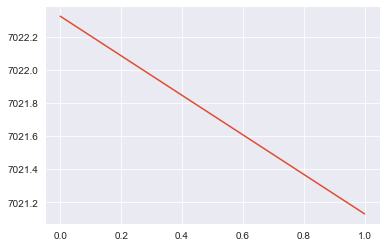

経過時間(実績)　= 0:02:55.323395 9902 / 10000 (99.01%)

score =  0.0326806079487516
lambda_p = 0.049999999999999996, alpha = 0.1, r_purchase = 0.06309573444801933
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:29.296027 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:08.440012 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.431877 5000002 / 5057824 (98.86%)

[7019.972230936636]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:29.697620 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:08.474819 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.605462 5000002 / 5057824 (98.86%)

[7019.972230936636, 7018.831791481587]


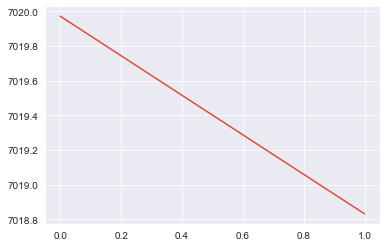

経過時間(実績)　= 0:02:55.616736 9902 / 10000 (99.01%)

score =  0.033007017567740424
lambda_p = 0.049999999999999996, alpha = 0.1, r_purchase = 0.3981071705534973
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:29.466081 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:08.207303 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.755574 5000002 / 5057824 (98.86%)

[7017.89985725325]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:30.355324 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:08.876450 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.560025 5000002 / 5057824 (98.86%)

[7017.89985725325, 7016.8643565302955]


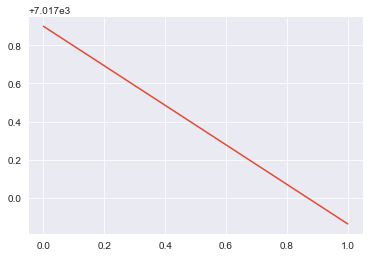

経過時間(実績)　= 0:02:56.521450 9902 / 10000 (99.01%)

score =  0.03335649593819851
lambda_p = 0.049999999999999996, alpha = 0.1, r_purchase = 2.5118864315095824
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:31.408307 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:08.316214 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.780450 5000002 / 5057824 (98.86%)

[7016.7071194457685]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:30.804055 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:08.148763 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.414946 5000002 / 5057824 (98.86%)

[7016.7071194457685, 7015.78268602609]


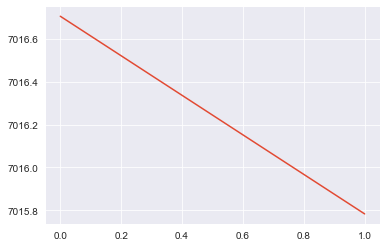

経過時間(実績)　= 0:02:55.595343 9902 / 10000 (99.01%)

score =  0.03337680814651059
lambda_p = 0.049999999999999996, alpha = 0.1, r_purchase = 15.848931924611142
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:30.676611 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:07.797570 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.005309 5000002 / 5057824 (98.86%)

[7017.444792792112]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:29.278288 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:08.528007 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.216939 5000002 / 5057824 (98.86%)

[7017.444792792112, 7016.650865243789]


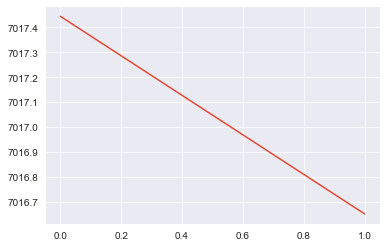

経過時間(実績)　= 0:02:55.476590 9902 / 10000 (99.01%)

score =  0.03335494680341804
lambda_p = 0.049999999999999996, alpha = 0.1, r_purchase = 100.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:29.720322 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:08.263224 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.919532 5000002 / 5057824 (98.86%)

[7018.503838397019]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:30.329241 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:07.365020 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.074913 5000002 / 5057824 (98.86%)

[7018.503838397019, 7018.03430135278]


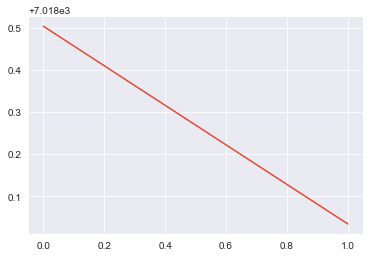

経過時間(実績)　= 0:02:51.998590 9902 / 10000 (99.01%)

score =  0.0334535494627389
lambda_p = 0.049999999999999996, alpha = 1.0, r_purchase = 0.01
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:28.045944 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.554291 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.332217 5000002 / 5057824 (98.86%)

[7013.402185520843]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:28.347021 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.761281 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.385494 5000002 / 5057824 (98.86%)

[7013.402185520843, 7012.798891746069]


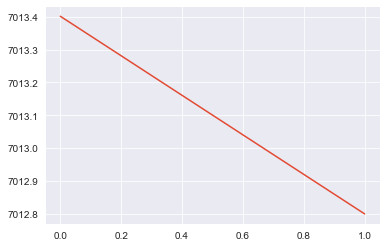

経過時間(実績)　= 0:02:50.821836 9902 / 10000 (99.01%)

score =  0.033114313566783474
lambda_p = 0.049999999999999996, alpha = 1.0, r_purchase = 0.06309573444801933
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:27.535664 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:07.238802 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.055290 5000002 / 5057824 (98.86%)

[7012.355523059764]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:27.782674 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:07.059014 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.315456 5000002 / 5057824 (98.86%)

[7012.355523059764, 7011.722733378763]


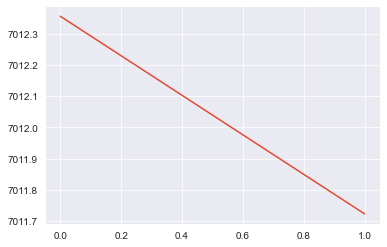

経過時間(実績)　= 0:02:51.612773 9902 / 10000 (99.01%)

score =  0.03342470469014337
lambda_p = 0.049999999999999996, alpha = 1.0, r_purchase = 0.3981071705534973
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:28.869733 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.314623 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.256051 5000002 / 5057824 (98.86%)

[7012.034040493545]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:28.961399 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:07.043541 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.000785 5000002 / 5057824 (98.86%)

[7012.034040493545, 7011.421740708668]


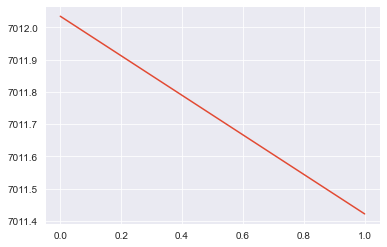

経過時間(実績)　= 0:02:50.409091 9902 / 10000 (99.01%)

score =  0.033475585542812804
lambda_p = 0.049999999999999996, alpha = 1.0, r_purchase = 2.5118864315095824
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:27.003740 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.399972 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.604124 5000002 / 5057824 (98.86%)

[7013.119529219064]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:26.096765 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.093454 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.628029 5000002 / 5057824 (98.86%)

[7013.119529219064, 7012.563864698941]


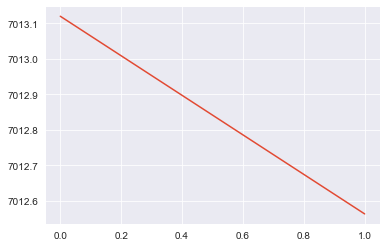

経過時間(実績)　= 0:02:49.744938 9902 / 10000 (99.01%)

score =  0.03364570726257245
lambda_p = 0.049999999999999996, alpha = 1.0, r_purchase = 15.848931924611142
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:26.505113 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.137381 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.566672 5000002 / 5057824 (98.86%)

[7013.870195375907]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:26.165571 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.975725 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.503295 5000002 / 5057824 (98.86%)

[7013.870195375907, 7013.579727326546]


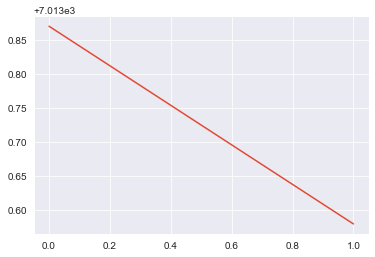

経過時間(実績)　= 0:02:48.236898 9902 / 10000 (99.01%)

score =  0.033132358482147274
lambda_p = 0.049999999999999996, alpha = 1.0, r_purchase = 100.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:25.834259 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.742864 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.099557 5000002 / 5057824 (98.86%)

[7013.877633729114]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:27.080512 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.387442 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.033892 5000002 / 5057824 (98.86%)

[7013.877633729114, 7013.799719017281]


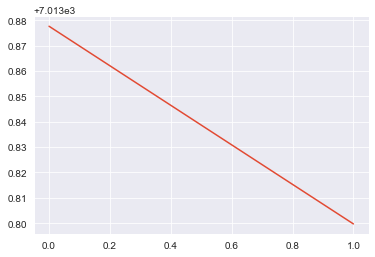

経過時間(実績)　= 0:02:49.147508 9902 / 10000 (99.01%)

score =  0.03314080584455529
lambda_p = 0.13572088082974532, alpha = 0.001, r_purchase = 0.01
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:25.967996 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.878679 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.247602 5000002 / 5057824 (98.86%)

[19006.444817543448]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:25.680365 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.161428 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.627584 5000002 / 5057824 (98.86%)

[19006.444817543448, 19001.70660380404]


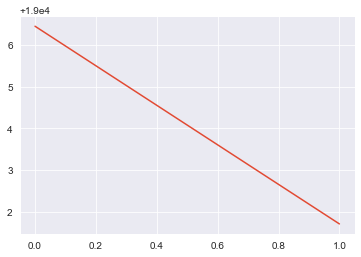

経過時間(実績)　= 0:02:48.804695 9902 / 10000 (99.01%)

score =  0.03393177820199333
lambda_p = 0.13572088082974532, alpha = 0.001, r_purchase = 0.06309573444801933
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:26.821731 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.177788 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.323224 5000002 / 5057824 (98.86%)

[18998.936577000306]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:25.435079 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.526548 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.661603 5000002 / 5057824 (98.86%)

[18998.936577000306, 18996.593545220636]


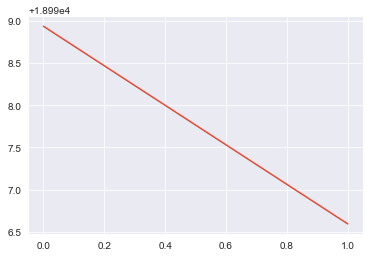

経過時間(実績)　= 0:02:49.612706 9902 / 10000 (99.01%)

score =  0.03332444217532297
lambda_p = 0.13572088082974532, alpha = 0.001, r_purchase = 0.3981071705534973
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:25.479175 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.076202 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.472252 5000002 / 5057824 (98.86%)

[18994.526423478685]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:26.578409 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.409672 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.608045 5000002 / 5057824 (98.86%)

[18994.526423478685, 18992.660227865457]


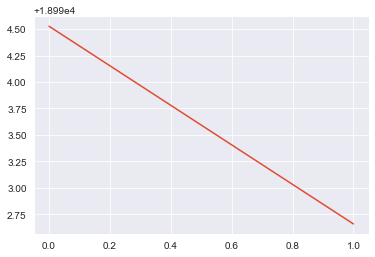

経過時間(実績)　= 0:02:49.565145 9902 / 10000 (99.01%)

score =  0.03338745115935339
lambda_p = 0.13572088082974532, alpha = 0.001, r_purchase = 2.5118864315095824
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:39.464345 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.692106 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.892930 5000002 / 5057824 (98.86%)

[18991.02186926665]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:25.425414 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.472014 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.135664 5000002 / 5057824 (98.86%)

[18991.02186926665, 18989.476155536424]


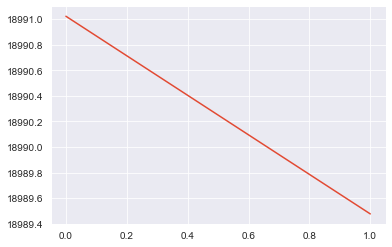

経過時間(実績)　= 0:02:50.368963 9902 / 10000 (99.01%)

score =  0.03303190957994609
lambda_p = 0.13572088082974532, alpha = 0.001, r_purchase = 15.848931924611142
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:27.498505 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:07.391133 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.436084 5000002 / 5057824 (98.86%)

[18988.395661003357]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:29.562256 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:07.656446 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.288111 5000002 / 5057824 (98.86%)

[18988.395661003357, 18987.063599825313]


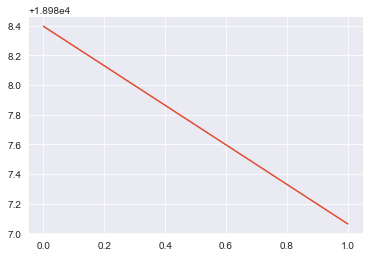

経過時間(実績)　= 0:02:52.453454 9902 / 10000 (99.01%)

score =  0.032489999001355525
lambda_p = 0.13572088082974532, alpha = 0.001, r_purchase = 100.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:30.289238 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:07.328022 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.990984 5000002 / 5057824 (98.86%)

[18987.802142568187]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:28.769429 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:12.042005 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:30.684849 5000002 / 5057824 (98.86%)

[18987.802142568187, 18986.40729718266]


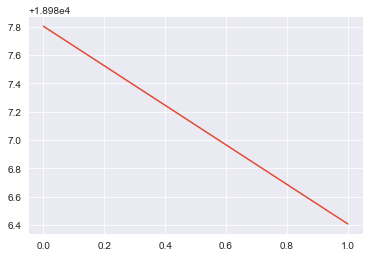

経過時間(実績)　= 0:02:57.929329 9902 / 10000 (99.01%)

score =  0.03209721931042097
lambda_p = 0.13572088082974532, alpha = 0.01, r_purchase = 0.01
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:27.987612 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:07.787760 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.470849 5000002 / 5057824 (98.86%)

[18983.199338201353]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:28.711224 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:07.662462 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.901670 5000002 / 5057824 (98.86%)

[18983.199338201353, 18982.53662445699]


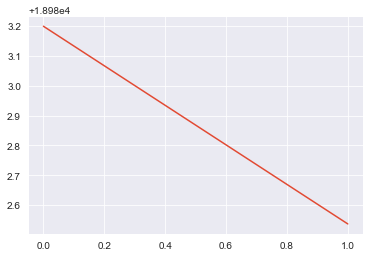

経過時間(実績)　= 0:02:54.559777 9902 / 10000 (99.01%)

score =  0.03157717591887445
lambda_p = 0.13572088082974532, alpha = 0.01, r_purchase = 0.06309573444801933
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:28.035202 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:07.664238 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.005534 5000002 / 5057824 (98.86%)

[18981.760812723067]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:30.257753 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.752740 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.821949 5000002 / 5057824 (98.86%)

[18981.760812723067, 18980.99487066014]


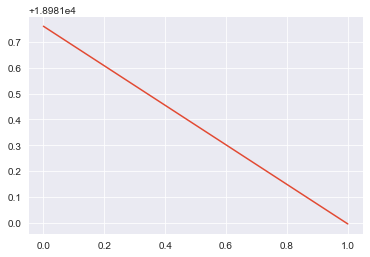

経過時間(実績)　= 0:02:49.117528 9902 / 10000 (99.01%)

score =  0.03101692931125195
lambda_p = 0.13572088082974532, alpha = 0.01, r_purchase = 0.3981071705534973
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:27.409224 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.680949 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.677448 5000002 / 5057824 (98.86%)

[18980.358423192214]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:27.349268 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.625979 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.432141 5000002 / 5057824 (98.86%)

[18980.358423192214, 18979.683082194606]


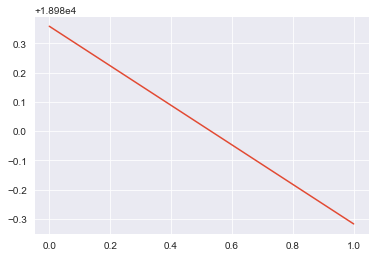

経過時間(実績)　= 0:02:48.290106 9902 / 10000 (99.01%)

score =  0.030702923838571188
lambda_p = 0.13572088082974532, alpha = 0.01, r_purchase = 2.5118864315095824
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:27.240343 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.962005 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.531761 5000002 / 5057824 (98.86%)

[18979.551579505023]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:27.485757 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.163646 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.393622 5000002 / 5057824 (98.86%)

[18979.551579505023, 18978.902753982078]


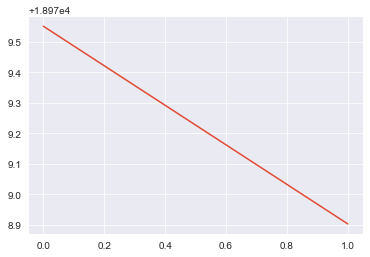

経過時間(実績)　= 0:02:49.444720 9902 / 10000 (99.01%)

score =  0.0304077226742217
lambda_p = 0.13572088082974532, alpha = 0.01, r_purchase = 15.848931924611142
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:26.843654 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.735849 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:26.195428 5000002 / 5057824 (98.86%)

[18981.124929144175]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:26.403779 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.641121 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.636122 5000002 / 5057824 (98.86%)

[18981.124929144175, 18980.086845325844]


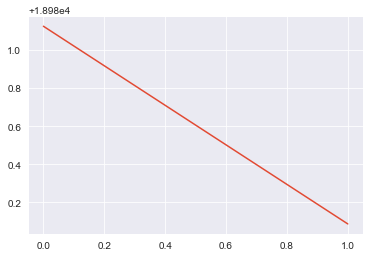

経過時間(実績)　= 0:02:49.454928 9902 / 10000 (99.01%)

score =  0.03045538771336308
lambda_p = 0.13572088082974532, alpha = 0.01, r_purchase = 100.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:27.066278 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.061593 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.662690 5000002 / 5057824 (98.86%)

[18990.78174200156]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:27.782897 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.009743 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.848870 5000002 / 5057824 (98.86%)

[18990.78174200156, 18987.212728712984]


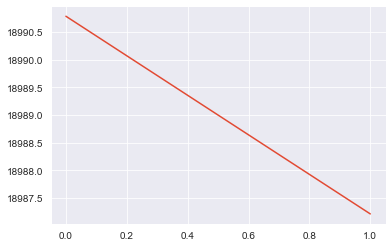

経過時間(実績)　= 0:02:49.325358 9902 / 10000 (99.01%)

score =  0.030600952102623608
lambda_p = 0.13572088082974532, alpha = 0.1, r_purchase = 0.01
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:27.087660 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.059879 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.376777 5000002 / 5057824 (98.86%)

[18974.75460587927]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:27.457103 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.892856 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.679787 5000002 / 5057824 (98.86%)

[18974.75460587927, 18975.481990345706]
======= t =  2 =========
update P
経過時間(実績)　= 0:01:28.308945 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.559377 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.839150 5000002 / 5057824 (98.86%)

[18974.75460587927, 18975.481990345706, 18975.509399582963]
======= t =  3 =========
u

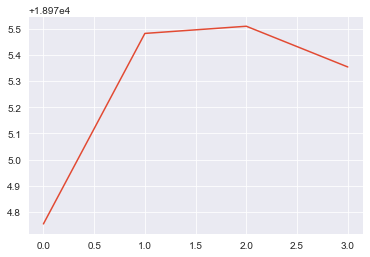

経過時間(実績)　= 0:02:49.858201 9902 / 10000 (99.01%)

score =  0.02951417758024432
lambda_p = 0.13572088082974532, alpha = 0.1, r_purchase = 0.06309573444801933
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:26.850315 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.009760 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.637279 5000002 / 5057824 (98.86%)

[18975.262325200976]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:28.262904 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.780697 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.963039 5000002 / 5057824 (98.86%)

[18975.262325200976, 18975.029619790905]


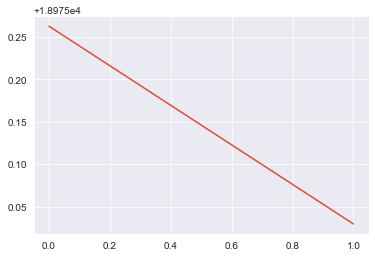

経過時間(実績)　= 0:02:49.707297 9902 / 10000 (99.01%)

score =  0.029087422210948278
lambda_p = 0.13572088082974532, alpha = 0.1, r_purchase = 0.3981071705534973
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:29.463072 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.878066 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.271312 5000002 / 5057824 (98.86%)

[18975.514899210943]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:26.771668 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.152751 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.666017 5000002 / 5057824 (98.86%)

[18975.514899210943, 18975.184463667687]


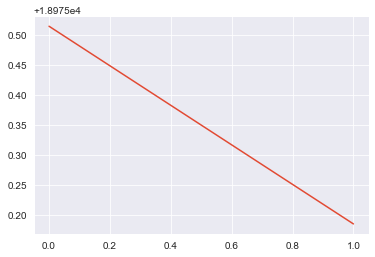

経過時間(実績)　= 0:02:50.274174 9902 / 10000 (99.01%)

score =  0.029030511663214055
lambda_p = 0.13572088082974532, alpha = 0.1, r_purchase = 2.5118864315095824
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:28.045700 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.113090 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.001518 5000002 / 5057824 (98.86%)

[18978.83196798549]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:28.256044 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.405480 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.054981 5000002 / 5057824 (98.86%)

[18978.83196798549, 18977.774455297804]


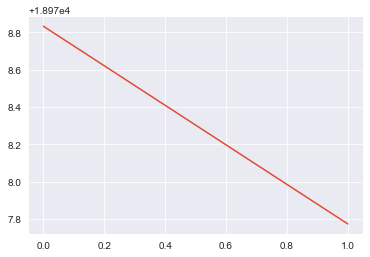

経過時間(実績)　= 0:02:49.492273 9902 / 10000 (99.01%)

score =  0.02909732308536834
lambda_p = 0.13572088082974532, alpha = 0.1, r_purchase = 15.848931924611142
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:29.278460 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.477525 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.554706 5000002 / 5057824 (98.86%)

[18990.930941862483]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:28.086462 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.902036 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.578877 5000002 / 5057824 (98.86%)

[18990.930941862483, 18986.566956409824]


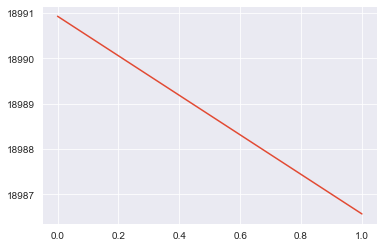

経過時間(実績)　= 0:02:49.501306 9902 / 10000 (99.01%)

score =  0.029343539620796673
lambda_p = 0.13572088082974532, alpha = 0.1, r_purchase = 100.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:27.671068 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.374198 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.554139 5000002 / 5057824 (98.86%)

[19001.653094973648]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:26.623184 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.146457 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.429287 5000002 / 5057824 (98.86%)

[19001.653094973648, 18995.446193858166]


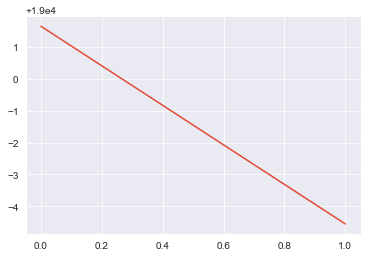

経過時間(実績)　= 0:02:50.318426 9902 / 10000 (99.01%)

score =  0.028971420884442056
lambda_p = 0.13572088082974532, alpha = 1.0, r_purchase = 0.01
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:26.900389 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.589173 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.014089 5000002 / 5057824 (98.86%)

[18972.680996247782]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:26.880777 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.126557 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.203922 5000002 / 5057824 (98.86%)

[18972.680996247782, 18973.551070658577]
======= t =  2 =========
update P
経過時間(実績)　= 0:01:27.057470 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:07.298979 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.570462 5000002 / 5057824 (98.86%)

[18972.680996247782, 18973.551070658577, 18973.91881884882]
======= t =  3 =========

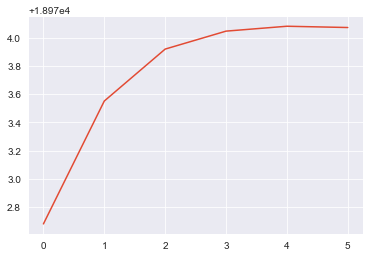

経過時間(実績)　= 0:02:50.091824 9902 / 10000 (99.01%)

score =  0.0279018732548582
lambda_p = 0.13572088082974532, alpha = 1.0, r_purchase = 0.06309573444801933
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:26.270831 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.886109 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.938578 5000002 / 5057824 (98.86%)

[18975.136166501878]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:27.010651 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.009285 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.456555 5000002 / 5057824 (98.86%)

[18975.136166501878, 18974.912787068988]


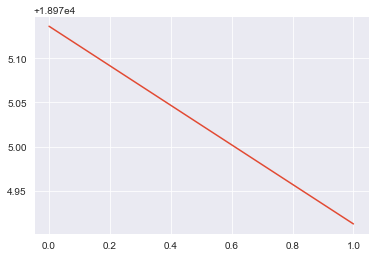

経過時間(実績)　= 0:02:50.796519 9902 / 10000 (99.01%)

score =  0.02786627200754741
lambda_p = 0.13572088082974532, alpha = 1.0, r_purchase = 0.3981071705534973
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:27.080889 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.269356 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.156716 5000002 / 5057824 (98.86%)

[18980.34403070202]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:27.555866 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.169029 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.159778 5000002 / 5057824 (98.86%)

[18980.34403070202, 18979.069970985634]


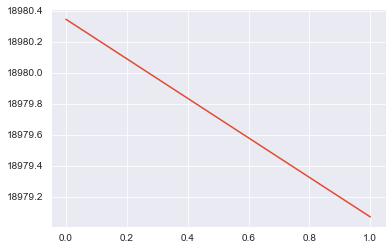

経過時間(実績)　= 0:02:48.757826 9902 / 10000 (99.01%)

score =  0.027947889178149086
lambda_p = 0.13572088082974532, alpha = 1.0, r_purchase = 2.5118864315095824
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:25.963773 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.163530 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.963669 5000002 / 5057824 (98.86%)

[18993.42206538165]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:28.605552 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.260675 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.281479 5000002 / 5057824 (98.86%)

[18993.42206538165, 18988.961790293102]


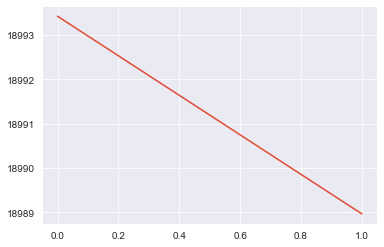

経過時間(実績)　= 0:02:51.018253 9902 / 10000 (99.01%)

score =  0.028489089973962673
lambda_p = 0.13572088082974532, alpha = 1.0, r_purchase = 15.848931924611142
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:27.726683 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.306410 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.400307 5000002 / 5057824 (98.86%)

[19000.37744786283]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:27.379087 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.450774 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.246311 5000002 / 5057824 (98.86%)

[19000.37744786283, 18995.619530851138]


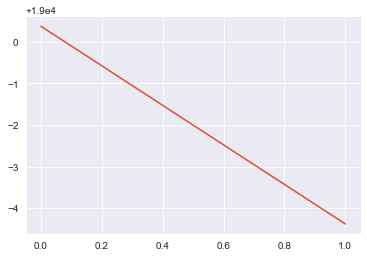

経過時間(実績)　= 0:02:50.783531 9902 / 10000 (99.01%)

score =  0.028871654306540238
lambda_p = 0.13572088082974532, alpha = 1.0, r_purchase = 100.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:29.445820 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:08.888610 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.898958 5000002 / 5057824 (98.86%)

[18997.383661802738]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:31.672990 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:08.568334 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.567003 5000002 / 5057824 (98.86%)

[18997.383661802738, 18994.98469067693]


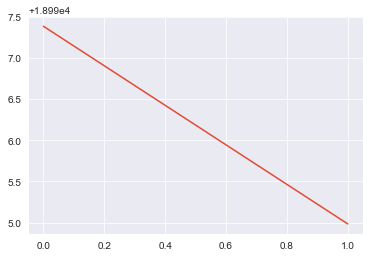

経過時間(実績)　= 0:02:54.786573 9902 / 10000 (99.01%)

score =  0.028300834510613705
lambda_p = 0.36840314986403866, alpha = 0.001, r_purchase = 0.01
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:30.105312 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:09.124829 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.217521 5000002 / 5057824 (98.86%)

[51422.79633834838]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:29.693987 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:07.968113 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.536223 5000002 / 5057824 (98.86%)

[51422.79633834838, 51388.13399328574]


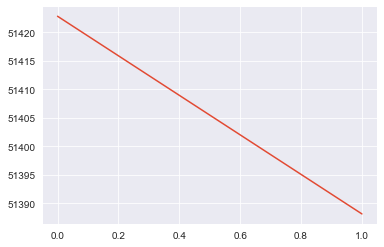

経過時間(実績)　= 0:02:55.792318 9902 / 10000 (99.01%)

score =  0.027000857679195002
lambda_p = 0.36840314986403866, alpha = 0.001, r_purchase = 0.06309573444801933
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:31.045515 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:09.007052 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.402273 5000002 / 5057824 (98.86%)

[51386.44087780194]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:30.713697 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:08.172832 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.473759 5000002 / 5057824 (98.86%)

[51386.44087780194, 51387.372917639615]
======= t =  2 =========
update P
経過時間(実績)　= 0:01:30.339457 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:08.603819 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.809496 5000002 / 5057824 (98.86%)

[51386.44087780194, 51387.372917639615, 51388.55065711598]
======= t 

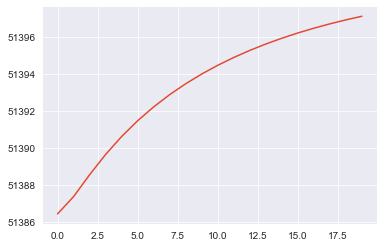

経過時間(実績)　= 0:02:36.197277 9902 / 10000 (99.01%)

score =  0.02061975586002917
lambda_p = 0.36840314986403866, alpha = 0.001, r_purchase = 0.3981071705534973
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:23.593262 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:01.196420 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:22.923227 5000002 / 5057824 (98.86%)

[51397.34288668303]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:25.026825 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:01.881461 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.614253 5000002 / 5057824 (98.86%)

[51397.34288668303, 51397.500015174395]
======= t =  2 =========
update P
経過時間(実績)　= 0:01:25.544934 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:02.410619 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.163428 5000002 / 5057824 (98.86%)

[51397.34288668303, 51397.500015174395, 51397.64712536292]
======= t = 

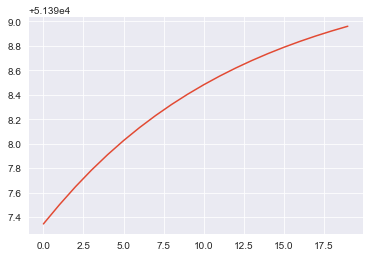

経過時間(実績)　= 0:02:43.316236 9902 / 10000 (99.01%)

score =  0.017916690197071823
lambda_p = 0.36840314986403866, alpha = 0.001, r_purchase = 2.5118864315095824
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:26.881184 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:07.572492 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.895078 5000002 / 5057824 (98.86%)

[51399.40652012788]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:18.106072 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:00:58.418402 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:22.603020 5000002 / 5057824 (98.86%)

[51399.40652012788, 51399.395116422005]


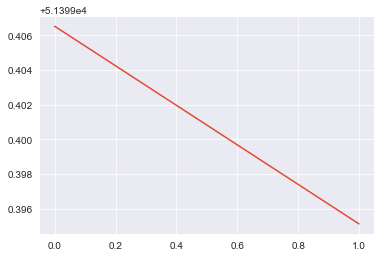

経過時間(実績)　= 0:02:35.335301 9902 / 10000 (99.01%)

score =  0.017824521432098436
lambda_p = 0.36840314986403866, alpha = 0.001, r_purchase = 15.848931924611142
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:17.036342 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:00:58.176297 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:22.908830 5000002 / 5057824 (98.86%)

[51401.95530254186]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:18.161415 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:00.101389 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.524022 5000002 / 5057824 (98.86%)

[51401.95530254186, 51401.69156819766]


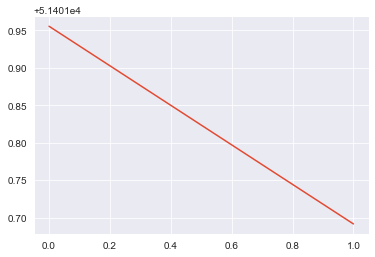

経過時間(実績)　= 0:02:40.736166 9902 / 10000 (99.01%)

score =  0.017706268101435375
lambda_p = 0.36840314986403866, alpha = 0.001, r_purchase = 100.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:31.177133 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:02.995236 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.485980 5000002 / 5057824 (98.86%)

[51416.38235738736]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:26.875706 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:02.859781 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.438712 5000002 / 5057824 (98.86%)

[51416.38235738736, 51414.52898759583]


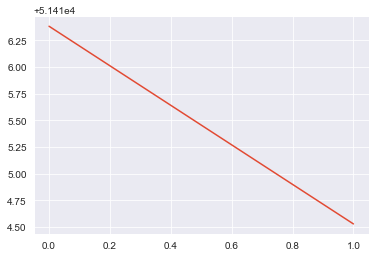

経過時間(実績)　= 0:02:43.290796 9902 / 10000 (99.01%)

score =  0.017668496401003635
lambda_p = 0.36840314986403866, alpha = 0.01, r_purchase = 0.01
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:26.028881 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:02.692026 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.628195 5000002 / 5057824 (98.86%)

[51396.93926511379]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:27.348568 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:02.801681 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.568687 5000002 / 5057824 (98.86%)

[51396.93926511379, 51398.06324425536]
======= t =  2 =========
update P
経過時間(実績)　= 0:01:27.080561 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:02.802289 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.060890 5000002 / 5057824 (98.86%)

[51396.93926511379, 51398.06324425536, 51398.62735861382]
======= t =  3 =========
upd

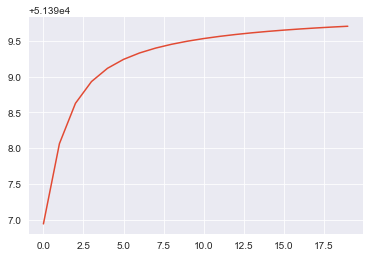

経過時間(実績)　= 0:02:50.624154 9902 / 10000 (99.01%)

score =  0.016283487477973067
lambda_p = 0.36840314986403866, alpha = 0.01, r_purchase = 0.06309573444801933
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:29.765886 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.424139 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.509495 5000002 / 5057824 (98.86%)

[51399.82005131659]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:28.900476 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:04.902316 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.601214 5000002 / 5057824 (98.86%)

[51399.82005131659, 51399.818403290585]


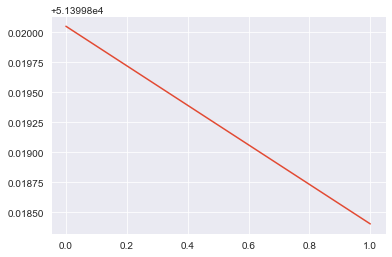

経過時間(実績)　= 0:02:47.164387 9902 / 10000 (99.01%)

score =  0.016261600679880087
lambda_p = 0.36840314986403866, alpha = 0.01, r_purchase = 0.3981071705534973
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:30.206690 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.235064 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.094926 5000002 / 5057824 (98.86%)

[51400.472955056364]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:30.472779 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.511080 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.986312 5000002 / 5057824 (98.86%)

[51400.472955056364, 51400.4077415184]


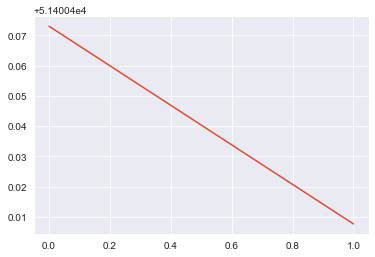

経過時間(実績)　= 0:02:49.571669 9902 / 10000 (99.01%)

score =  0.016125259772848507
lambda_p = 0.36840314986403866, alpha = 0.01, r_purchase = 2.5118864315095824
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:28.632050 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:04.755327 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.897315 5000002 / 5057824 (98.86%)

[51404.39690619232]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:30.300737 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:04.691208 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.002890 5000002 / 5057824 (98.86%)

[51404.39690619232, 51403.94180180725]


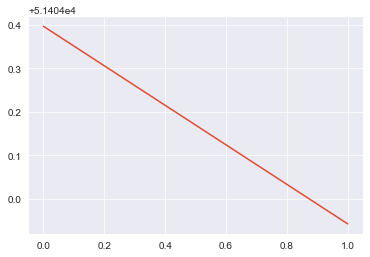

経過時間(実績)　= 0:02:47.446557 9902 / 10000 (99.01%)

score =  0.015941158870359632
lambda_p = 0.36840314986403866, alpha = 0.01, r_purchase = 15.848931924611142
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:29.537350 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:04.839227 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.803678 5000002 / 5057824 (98.86%)

[51426.10886611593]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:30.698848 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:04.947767 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.320034 5000002 / 5057824 (98.86%)

[51426.10886611593, 51423.07867258593]


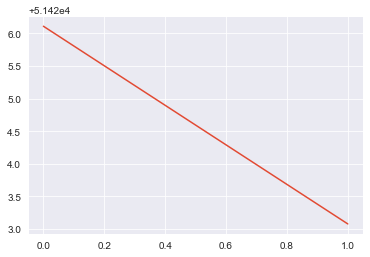

経過時間(実績)　= 0:02:46.919751 9902 / 10000 (99.01%)

score =  0.015994215587872604
lambda_p = 0.36840314986403866, alpha = 0.01, r_purchase = 100.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:29.146143 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:04.580388 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.573095 5000002 / 5057824 (98.86%)

[51513.95536453227]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:29.755088 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:04.691756 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.093756 5000002 / 5057824 (98.86%)

[51513.95536453227, 51488.72646667755]


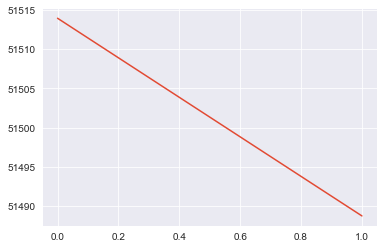

経過時間(実績)　= 0:02:48.854408 9902 / 10000 (99.01%)

score =  0.015749967775181384
lambda_p = 0.36840314986403866, alpha = 0.1, r_purchase = 0.01
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:28.666077 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:04.645915 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.337702 5000002 / 5057824 (98.86%)

[51391.44282578857]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:31.624766 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:04.401035 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.533319 5000002 / 5057824 (98.86%)

[51391.44282578857, 51394.090495514]
======= t =  2 =========
update P
経過時間(実績)　= 0:01:33.002653 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.464359 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.615130 5000002 / 5057824 (98.86%)

[51391.44282578857, 51394.090495514, 51397.0837578717]
======= t =  3 =========
update P


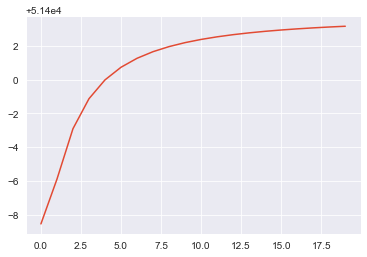

経過時間(実績)　= 0:02:46.773453 9902 / 10000 (99.01%)

score =  0.014972837371198509
lambda_p = 0.36840314986403866, alpha = 0.1, r_purchase = 0.06309573444801933
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:29.993428 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:04.944038 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.273993 5000002 / 5057824 (98.86%)

[51404.23201017878]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:18.488452 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:00:59.505546 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.086739 5000002 / 5057824 (98.86%)

[51404.23201017878, 51404.15950869234]


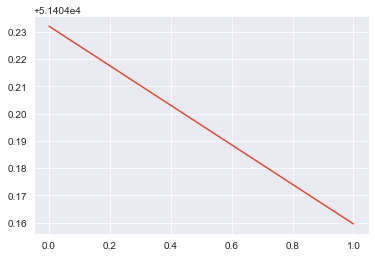

経過時間(実績)　= 0:03:08.400679 9902 / 10000 (99.01%)

score =  0.014895062745788031
lambda_p = 0.36840314986403866, alpha = 0.1, r_purchase = 0.3981071705534973
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:37.612186 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:15.548460 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:26.386987 5000002 / 5057824 (98.86%)

[51410.44515391218]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:37.757789 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:14.327905 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:26.618711 5000002 / 5057824 (98.86%)

[51410.44515391218, 51409.76250168259]


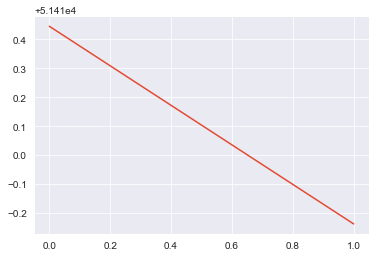

経過時間(実績)　= 0:03:09.446664 9902 / 10000 (99.01%)

score =  0.014842589803107376
lambda_p = 0.36840314986403866, alpha = 0.1, r_purchase = 2.5118864315095824
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:38.805483 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:13.148169 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:26.249076 5000002 / 5057824 (98.86%)

[51442.59436241227]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:35.866923 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:12.944787 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:26.068224 5000002 / 5057824 (98.86%)

[51442.59436241227, 51437.69609533341]


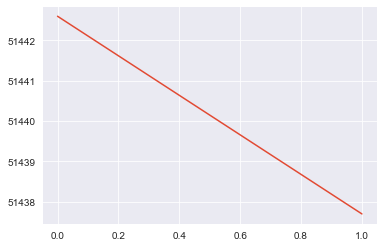

経過時間(実績)　= 0:03:06.631051 9902 / 10000 (99.01%)

score =  0.015162657652850721
lambda_p = 0.36840314986403866, alpha = 0.1, r_purchase = 15.848931924611142
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:34.797931 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:14.458517 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.584471 5000002 / 5057824 (98.86%)

[51556.56099918708]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:36.479108 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:12.261281 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.984350 5000002 / 5057824 (98.86%)

[51556.56099918708, 51519.043455100116]


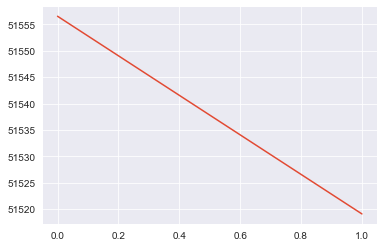

経過時間(実績)　= 0:03:02.764318 9902 / 10000 (99.01%)

score =  0.015067612807755586
lambda_p = 0.36840314986403866, alpha = 0.1, r_purchase = 100.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:32.343106 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:11.432405 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.899588 5000002 / 5057824 (98.86%)

[51695.5577174044]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:33.881124 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:10.908197 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.037560 5000002 / 5057824 (98.86%)

[51695.5577174044, 51629.08975744687]


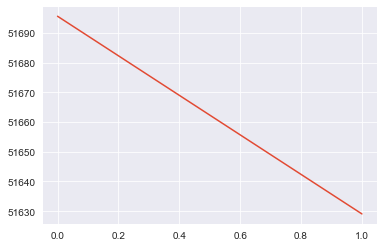

経過時間(実績)　= 0:03:02.610678 9902 / 10000 (99.01%)

score =  0.015625947871036425
lambda_p = 0.36840314986403866, alpha = 1.0, r_purchase = 0.01
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:33.561002 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:12.471464 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.533101 5000002 / 5057824 (98.86%)

[51396.53386518032]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:37.690568 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:11.261264 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.778346 5000002 / 5057824 (98.86%)

[51396.53386518032, 51398.36001760578]
======= t =  2 =========
update P
経過時間(実績)　= 0:01:33.519937 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:11.277808 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.530530 5000002 / 5057824 (98.86%)

[51396.53386518032, 51398.36001760578, 51403.562216255756]
======= t =  3 =========
upd

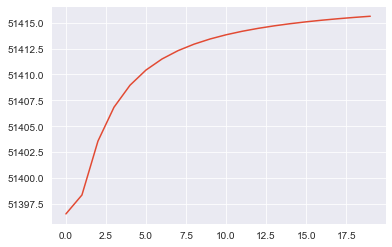

経過時間(実績)　= 0:03:06.115431 9902 / 10000 (99.01%)

score =  0.014552482515064559
lambda_p = 0.36840314986403866, alpha = 1.0, r_purchase = 0.06309573444801933
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:32.671010 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:10.923742 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:26.206930 5000002 / 5057824 (98.86%)

[51426.10694326512]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:33.162885 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:11.421382 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.868327 5000002 / 5057824 (98.86%)

[51426.10694326512, 51425.22241847155]


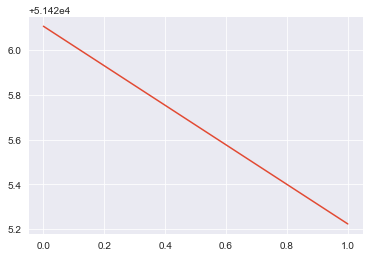

経過時間(実績)　= 0:03:02.935387 9902 / 10000 (99.01%)

score =  0.014834741525870408
lambda_p = 0.36840314986403866, alpha = 1.0, r_purchase = 0.3981071705534973
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:33.185589 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:11.587023 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:26.059537 5000002 / 5057824 (98.86%)

[51474.20626994843]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:33.354895 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:11.645787 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.807299 5000002 / 5057824 (98.86%)

[51474.20626994843, 51466.98554417422]


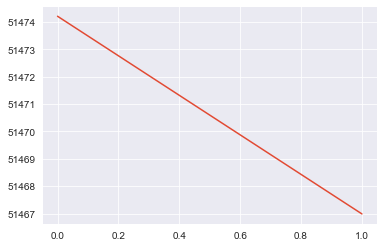

経過時間(実績)　= 0:03:02.128877 9902 / 10000 (99.01%)

score =  0.014847270102337638
lambda_p = 0.36840314986403866, alpha = 1.0, r_purchase = 2.5118864315095824
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:33.030347 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:11.064664 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:27.107548 5000002 / 5057824 (98.86%)

[51607.567785958636]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:34.301832 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:11.489296 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.623102 5000002 / 5057824 (98.86%)

[51607.567785958636, 51563.05758886104]


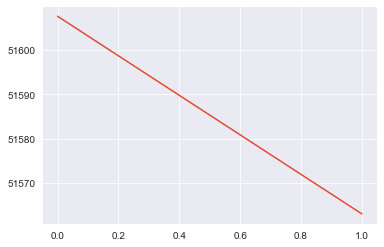

経過時間(実績)　= 0:03:02.522533 9902 / 10000 (99.01%)

score =  0.015948952348675292
lambda_p = 0.36840314986403866, alpha = 1.0, r_purchase = 15.848931924611142
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:33.338358 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:10.959018 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:26.198861 5000002 / 5057824 (98.86%)

[51709.628115989544]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:32.785373 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:11.654507 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.967033 5000002 / 5057824 (98.86%)

[51709.628115989544, 51653.11268346297]


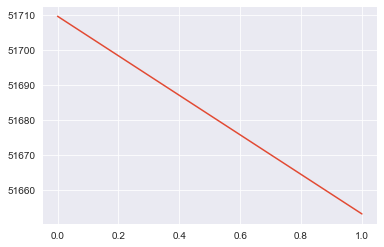

経過時間(実績)　= 0:03:01.251088 9902 / 10000 (99.01%)

score =  0.01652093290019498
lambda_p = 0.36840314986403866, alpha = 1.0, r_purchase = 100.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:32.496583 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:11.696179 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.657204 5000002 / 5057824 (98.86%)

[51693.37867084535]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:33.421166 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:11.688098 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.449390 5000002 / 5057824 (98.86%)

[51693.37867084535, 51640.92300145325]


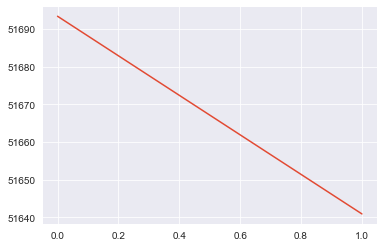

経過時間(実績)　= 0:03:02.515562 9902 / 10000 (99.01%)

score =  0.016645434644951662
lambda_p = 1.0, alpha = 0.001, r_purchase = 0.01
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:35.550027 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:13.308152 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:26.420144 5000002 / 5057824 (98.86%)

[138345.74628339458]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:36.759103 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:13.726187 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:26.302819 5000002 / 5057824 (98.86%)

[138345.74628339458, 138201.03770283627]


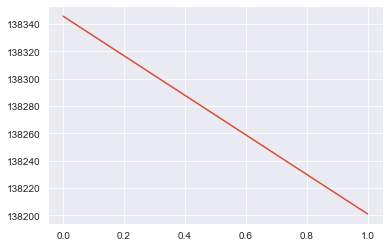

経過時間(実績)　= 0:03:09.884177 9902 / 10000 (99.01%)

score =  0.015253942994014488
lambda_p = 1.0, alpha = 0.001, r_purchase = 0.06309573444801933
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:37.892603 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:13.276312 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.833032 5000002 / 5057824 (98.86%)

[138224.63543322735]
======= t =  1 =========
update P
経過時間(実績)　= 0:02:18.273611 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:10.265674 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.469288 5000002 / 5057824 (98.86%)

[138224.63543322735, 138242.86567881895]
======= t =  2 =========
update P
経過時間(実績)　= 0:01:34.499324 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.534643 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.168604 5000002 / 5057824 (98.86%)

[138224.63543322735, 138242.86567881895, 138254.9081457642]
======= t =  3 ========

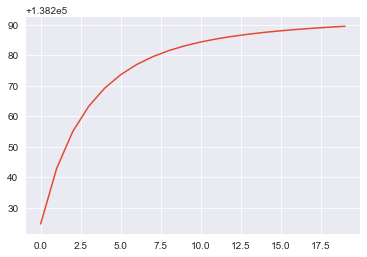

経過時間(実績)　= 0:02:47.358984 9902 / 10000 (99.01%)

score =  0.011849441300456917
lambda_p = 1.0, alpha = 0.001, r_purchase = 0.3981071705534973
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:18.104141 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:11.094642 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:26.303145 5000002 / 5057824 (98.86%)

[138290.74234943802]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:37.799763 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:14.174364 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:26.202046 5000002 / 5057824 (98.86%)

[138290.74234943802, 138290.89634183366]
======= t =  2 =========
update P
経過時間(実績)　= 0:01:39.168082 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:15.613055 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.922937 5000002 / 5057824 (98.86%)

[138290.74234943802, 138290.89634183366, 138291.09245976372]
======= t =  3 ========

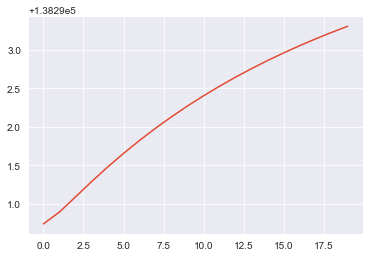

経過時間(実績)　= 0:03:03.839492 9902 / 10000 (99.01%)

score =  0.010195770171800147
lambda_p = 1.0, alpha = 0.001, r_purchase = 2.5118864315095824
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:34.891561 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:12.590153 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.199316 5000002 / 5057824 (98.86%)

[138299.6972905193]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:35.374289 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:12.005724 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.494840 5000002 / 5057824 (98.86%)

[138299.6972905193, 138299.13192331788]


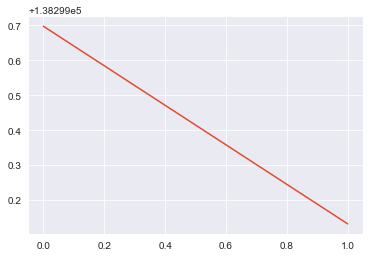

経過時間(実績)　= 0:03:05.418772 9902 / 10000 (99.01%)

score =  0.010130054533878417
lambda_p = 1.0, alpha = 0.001, r_purchase = 15.848931924611142
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:34.842097 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:12.132213 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.055111 5000002 / 5057824 (98.86%)

[138338.4016868873]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:35.075062 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:12.091107 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.642362 5000002 / 5057824 (98.86%)

[138338.4016868873, 138334.31475142261]


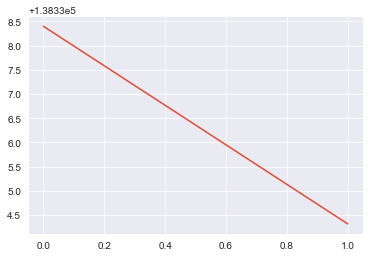

経過時間(実績)　= 0:03:03.366797 9902 / 10000 (99.01%)

score =  0.010102450245041885
lambda_p = 1.0, alpha = 0.001, r_purchase = 100.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:34.165442 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:12.253822 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.398734 5000002 / 5057824 (98.86%)

[138566.12627794145]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:35.332924 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:11.848479 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.736513 5000002 / 5057824 (98.86%)

[138566.12627794145, 138539.6149645887]


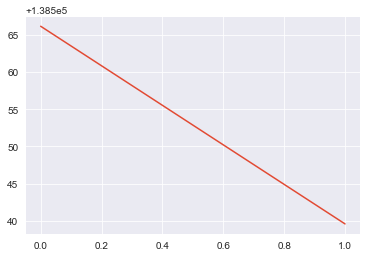

経過時間(実績)　= 0:03:05.110167 9902 / 10000 (99.01%)

score =  0.009770304439264715
lambda_p = 1.0, alpha = 0.01, r_purchase = 0.01
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:33.855088 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:12.434545 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.747443 5000002 / 5057824 (98.86%)

[138261.2146883171]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:34.833924 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:11.631800 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.978765 5000002 / 5057824 (98.86%)

[138261.2146883171, 138281.81151288038]
======= t =  2 =========
update P
経過時間(実績)　= 0:01:34.449375 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:12.259752 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.128276 5000002 / 5057824 (98.86%)

[138261.2146883171, 138281.81151288038, 138288.93415228964]
======= t =  3 =========
update P
経過時間(実績

経過時間(実績)　= 0:00:24.714244 5000002 / 5057824 (98.86%)

[138261.2146883171, 138281.81151288038, 138288.93415228964, 138292.1342490371, 138293.84328139154, 138294.87183973816, 138295.5456850384, 138296.01543432503, 138296.35869509575, 138296.61899482599, 138296.82243367608, 138296.98551377188, 138297.11911962775, 138297.23067986153, 138297.32540842975, 138297.4070509459, 138297.47835155373, 138297.5413553944, 138297.59760975462, 138297.64830099643]


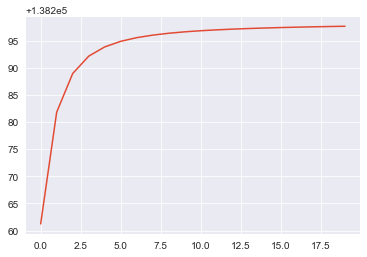

経過時間(実績)　= 0:03:05.700135 9902 / 10000 (99.01%)

score =  0.009433350052768534
lambda_p = 1.0, alpha = 0.01, r_purchase = 0.06309573444801933
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:34.593120 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:12.770620 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.114955 5000002 / 5057824 (98.86%)

[138299.28522757432]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:36.740357 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:11.811759 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.097651 5000002 / 5057824 (98.86%)

[138299.28522757432, 138299.16797522423]


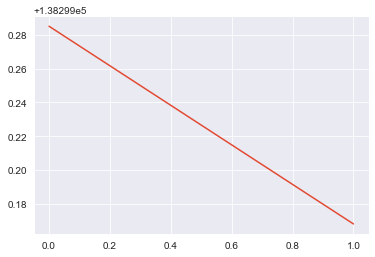

経過時間(実績)　= 0:03:13.987056 9902 / 10000 (99.01%)

score =  0.009414322924370031
lambda_p = 1.0, alpha = 0.01, r_purchase = 0.3981071705534973
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:33.522305 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:12.255404 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.223384 5000002 / 5057824 (98.86%)

[138309.15875183226]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:34.160785 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:12.164110 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.560251 5000002 / 5057824 (98.86%)

[138309.15875183226, 138308.1583438553]


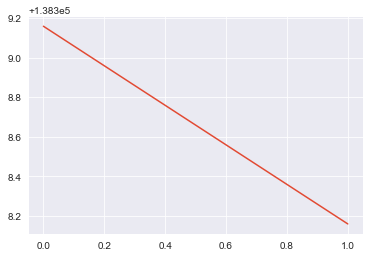

経過時間(実績)　= 0:03:03.639830 9902 / 10000 (99.01%)

score =  0.009409080265708684
lambda_p = 1.0, alpha = 0.01, r_purchase = 2.5118864315095824
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:33.769210 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:11.971555 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:26.568265 5000002 / 5057824 (98.86%)

[138369.91775653916]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:35.623395 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:11.866360 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:26.830015 5000002 / 5057824 (98.86%)

[138369.91775653916, 138363.3628752095]


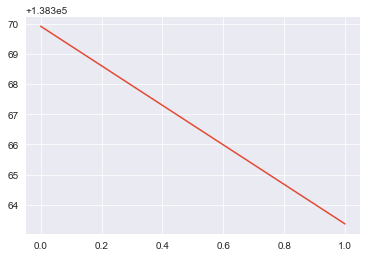

経過時間(実績)　= 0:03:04.975217 9902 / 10000 (99.01%)

score =  0.009369586842226942
lambda_p = 1.0, alpha = 0.01, r_purchase = 15.848931924611142
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:34.258380 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:13.758926 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.344067 5000002 / 5057824 (98.86%)

[138715.79855159283]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:34.646866 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:12.132868 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:26.009915 5000002 / 5057824 (98.86%)

[138715.79855159283, 138673.85106871827]


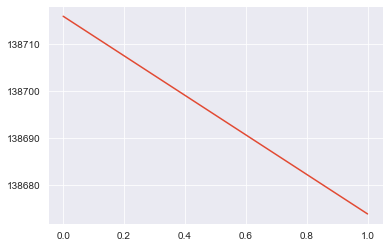

経過時間(実績)　= 0:03:04.099154 9902 / 10000 (99.01%)

score =  0.00907495113301484
lambda_p = 1.0, alpha = 0.01, r_purchase = 100.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:34.454317 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:12.084599 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.768204 5000002 / 5057824 (98.86%)

[140093.80844762485]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:35.557596 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:12.103261 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.928711 5000002 / 5057824 (98.86%)

[140093.80844762485, 139829.59206976864]


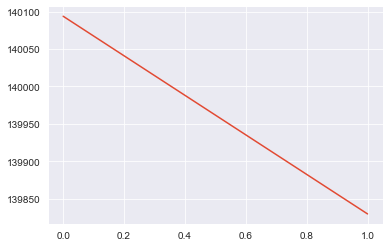

経過時間(実績)　= 0:03:05.256023 9902 / 10000 (99.01%)

score =  0.009717226256598153
lambda_p = 1.0, alpha = 0.1, r_purchase = 0.01
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:34.874695 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:12.136947 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.688842 5000002 / 5057824 (98.86%)

[138189.71197078624]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:36.443645 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:11.998730 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.472011 5000002 / 5057824 (98.86%)

[138189.71197078624, 138258.0496126833]
======= t =  2 =========
update P
経過時間(実績)　= 0:01:35.801595 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:12.352279 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.103924 5000002 / 5057824 (98.86%)

[138189.71197078624, 138258.0496126833, 138291.29611035396]
======= t =  3 =========
update P
経過時間(実績

経過時間(実績)　= 0:00:25.260614 5000002 / 5057824 (98.86%)

[138189.71197078624, 138258.0496126833, 138291.29611035396, 138307.37664808193, 138316.3433775897, 138321.89403889305, 138325.59203912137, 138328.1890700404, 138330.08561059728, 138331.51287633093, 138332.61303225497, 138333.4779380907, 138334.16934270834, 138334.73009916293, 138335.19073404712, 138335.57347051863, 138335.89478713964, 138336.1670976667, 138336.3998836743, 138336.60047678175]


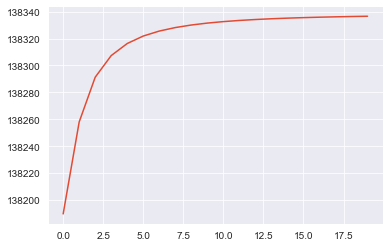

経過時間(実績)　= 0:03:07.642045 9902 / 10000 (99.01%)

score =  0.008719778028446003
lambda_p = 1.0, alpha = 0.1, r_purchase = 0.06309573444801933
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:25.210645 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.585967 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.659523 5000002 / 5057824 (98.86%)

[138352.62673586965]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:27.628670 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.456804 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.336357 5000002 / 5057824 (98.86%)

[138352.62673586965, 138351.19605635613]


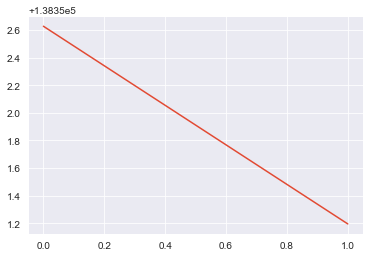

経過時間(実績)　= 0:02:59.420725 9902 / 10000 (99.01%)

score =  0.008703263649925654
lambda_p = 1.0, alpha = 0.1, r_purchase = 0.3981071705534973
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:34.230000 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:11.976380 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:26.083806 5000002 / 5057824 (98.86%)

[138448.1597934834]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:33.813711 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:12.268337 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.226190 5000002 / 5057824 (98.86%)

[138448.1597934834, 138437.91407965415]


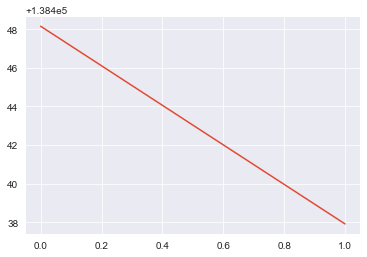

経過時間(実績)　= 0:03:03.793875 9902 / 10000 (99.01%)

score =  0.008820285222259675
lambda_p = 1.0, alpha = 0.1, r_purchase = 2.5118864315095824
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:34.556100 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:11.581334 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:26.177153 5000002 / 5057824 (98.86%)

[138962.49440960836]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:34.087983 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:13.135963 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:26.133449 5000002 / 5057824 (98.86%)

[138962.49440960836, 138897.4219642195]


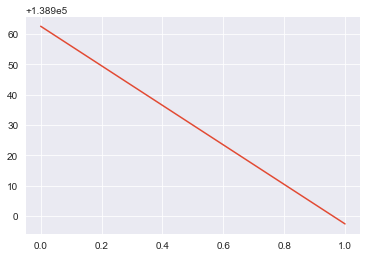

経過時間(実績)　= 0:03:04.166378 9902 / 10000 (99.01%)

score =  0.009052023554815457
lambda_p = 1.0, alpha = 0.1, r_purchase = 15.848931924611142
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:33.167713 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:11.300123 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:26.004708 5000002 / 5057824 (98.86%)

[140701.56792558482]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:35.175648 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:11.550406 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.771921 5000002 / 5057824 (98.86%)

[140701.56792558482, 140225.5279399698]


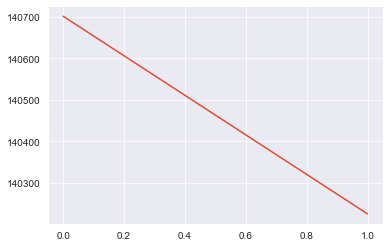

経過時間(実績)　= 0:03:02.886620 9902 / 10000 (99.01%)

score =  0.010265443566361136
lambda_p = 1.0, alpha = 0.1, r_purchase = 100.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:34.843253 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:12.293204 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:26.350057 5000002 / 5057824 (98.86%)

[141727.32277405955]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:34.637136 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:12.223233 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.953550 5000002 / 5057824 (98.86%)

[141727.32277405955, 140663.29282471165]
======= t =  2 =========
update P
経過時間(実績)　= 0:01:35.230258 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:12.628489 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.882932 5000002 / 5057824 (98.86%)

[141727.32277405955, 140663.29282471165, 140318.28450496303]


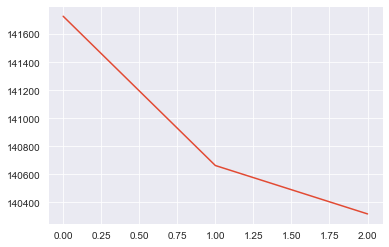

経過時間(実績)　= 0:03:04.165073 9902 / 10000 (99.01%)

score =  0.010925361696247226
lambda_p = 1.0, alpha = 1.0, r_purchase = 0.01
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:33.202563 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:12.315096 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.774116 5000002 / 5057824 (98.86%)

[138275.51580870076]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:35.224024 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:11.896817 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:26.166815 5000002 / 5057824 (98.86%)

[138275.51580870076, 138339.36428504292]
======= t =  2 =========
update P
経過時間(実績)　= 0:01:34.069899 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:11.875324 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.943886 5000002 / 5057824 (98.86%)

[138275.51580870076, 138339.36428504292, 138400.53564389906]
======= t =  3 =========
update P
経過時間(

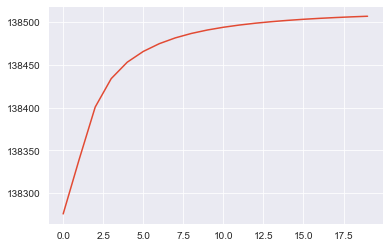

経過時間(実績)　= 0:02:39.007738 9902 / 10000 (99.01%)

score =  0.008791796584748482
lambda_p = 1.0, alpha = 1.0, r_purchase = 0.06309573444801933
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:24.379606 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:02.124233 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.322077 5000002 / 5057824 (98.86%)

[138662.41732514658]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:26.331415 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:01.968859 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.004307 5000002 / 5057824 (98.86%)

[138662.41732514658, 138647.76258967965]


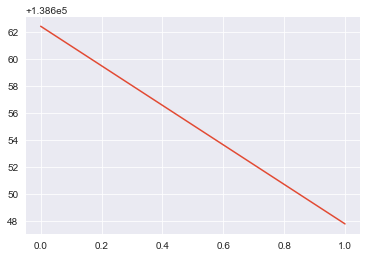

経過時間(実績)　= 0:02:40.891584 9902 / 10000 (99.01%)

score =  0.008967293443702474
lambda_p = 1.0, alpha = 1.0, r_purchase = 0.3981071705534973
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:27.490943 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:02.125882 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.247920 5000002 / 5057824 (98.86%)

[139417.78524248934]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:25.200680 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:02.425373 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.053312 5000002 / 5057824 (98.86%)

[139417.78524248934, 139325.73146622686]


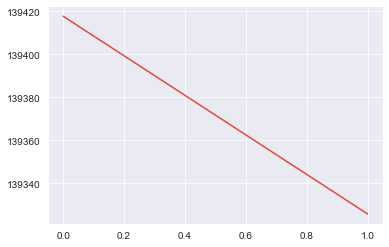

経過時間(実績)　= 0:02:38.687450 9902 / 10000 (99.01%)

score =  0.010153809131808078
lambda_p = 1.0, alpha = 1.0, r_purchase = 2.5118864315095824
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:25.334273 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:03.330612 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.560516 5000002 / 5057824 (98.86%)

[141414.82837038487]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:26.114149 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:04.068449 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.995895 5000002 / 5057824 (98.86%)

[141414.82837038487, 140554.04517596305]
======= t =  2 =========
update P
経過時間(実績)　= 0:01:25.240114 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:02.362444 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.533805 5000002 / 5057824 (98.86%)

[141414.82837038487, 140554.04517596305, 140036.63492927502]


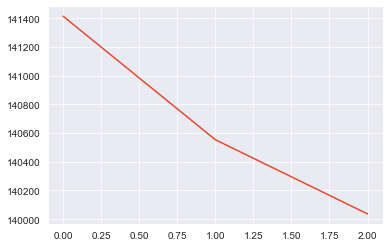

経過時間(実績)　= 0:02:40.174454 9902 / 10000 (99.01%)

score =  0.011914569225996124
lambda_p = 1.0, alpha = 1.0, r_purchase = 15.848931924611142
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:24.035728 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:02.061356 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.034217 5000002 / 5057824 (98.86%)

[141147.1992105042]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:25.177676 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:02.520179 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.086712 5000002 / 5057824 (98.86%)

[141147.1992105042, 140661.36431081718]


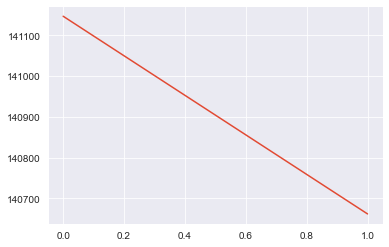

経過時間(実績)　= 0:02:39.533696 9902 / 10000 (99.01%)

score =  0.013890968093859956
lambda_p = 1.0, alpha = 1.0, r_purchase = 100.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:25.814755 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:01.619361 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.009312 5000002 / 5057824 (98.86%)

[141088.3191286699]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:27.311992 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:02.152866 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.577392 5000002 / 5057824 (98.86%)

[141088.3191286699, 140573.58694771663]


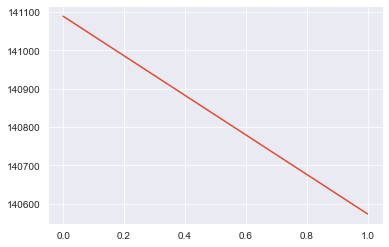

経過時間(実績)　= 0:02:39.580620 9902 / 10000 (99.01%)

score =  0.01571266241240303


In [59]:
num_iteration = 20
threshold_break = 0.005 # lossの改善が0.5%以下になったらbreak
k_dim = 100

#model = matrix_factorization(df_R_train, df_item_features, k_dim, alpha = alpha_start, r_purchase = r_purchase_start, \
                             #lambda_p = lambda_p_start, lambda_q = lambda_p_start)

# path_data_temp = r'C:\Users\yota-\Desktop\study\mystudy\recsys\dressipi_recsys2022\data\temp'
# model.df_P = pd.read_pickle(path_data_temp + r'\df_P_IMF_k' + str(k_dim) + r'.pkl')
# model.df_Q = pd.read_pickle(path_data_temp + r'\df_Q_IMF_k' + str(k_dim) + r'.pkl')
# model.df_P = df_P_rec
# model.df_Q = df_Q_rec
model.update(10, threshold_break)

score_list_list = []

df_score = pd.DataFrame(columns = ["lambda_p", "alpha", "r_purchase", "score"])
idx_param = 0

for lambda_p in lambda_p_list:
    for alpha in alpha_list:
        for r_purchase in r_purchase_list:
            print("lambda_p = {:0}, alpha = {:1}, r_purchase = {:2}".format(lambda_p, alpha, r_purchase))
            model.reset_params(alpha, r_purchase, lambda_p = lambda_p, lambda_q = lambda_p)

            loss_list = model.update(num_iteration, threshold_break)
            if len(loss_list) > 1:
                plt.plot(range(len(loss_list)), loss_list)
                plt.show()

            # スコアの算出
            df_y_pred = model.predict_items(df_X_valid, df_candidate_items)
            score = mean_reciprocal_rank(df_y_valid, df_y_pred)
            
            df_score.loc[idx_param] = [lambda_p, alpha, r_purchase, score]
            print("score = ", score)
            idx_param += 1

0.049999999999999996
0.13572088082974532
0.36840314986403866
1.0


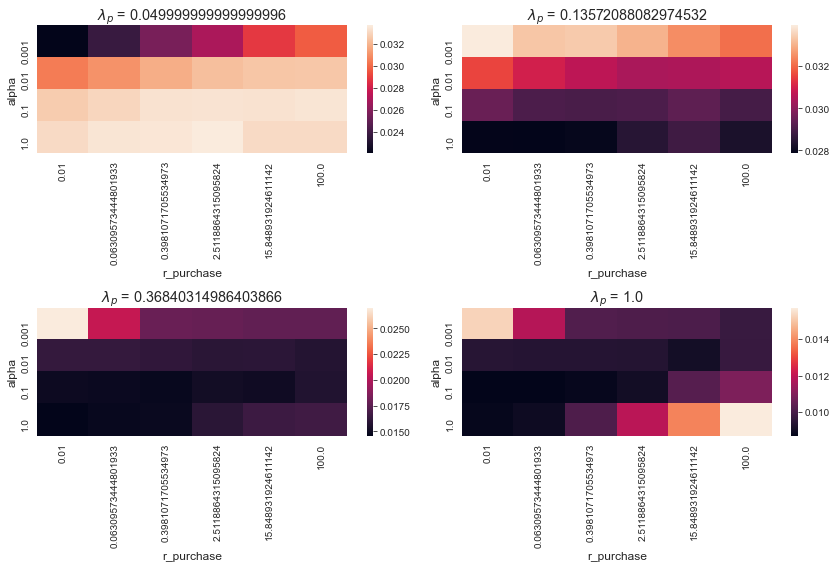

In [60]:
fig = plt.figure(figsize = (12, 8))


for idx, lambda_p in enumerate(df_score["lambda_p"].unique()):
    plt.subplot(2, 2, idx + 1)
    print(lambda_p)
    plt.title("$\lambda_p$ = {:}".format(lambda_p))
    sns.heatmap(df_score[df_score["lambda_p"] == lambda_p].pivot(index = "alpha", columns = "r_purchase", values = "score"), )
plt.tight_layout()
plt.show()
    

In [61]:
df_score.to_excel("df_score2.xlsx")

In [62]:
alpha_start = 0.001
alpha_end = 1.0
alpha_num = 4
alpha_list = np.geomspace(alpha_start, alpha_end, alpha_num)

r_purchase_start = 0.01
r_purchase_end = 100.0
r_purchase_num = 6
r_purchase_list = np.geomspace(r_purchase_start, r_purchase_end, r_purchase_num)

lambda_p_start = 0.05
lambda_p_end = 1.0
lambda_p_num = 4
lambda_p_list = np.geomspace(lambda_p_start, lambda_p_end, lambda_p_num)
print(alpha_list)
print(r_purchase_list)
print(lambda_p_list)

[0.001 0.01  0.1   1.   ]
[1.00000000e-02 6.30957344e-02 3.98107171e-01 2.51188643e+00
 1.58489319e+01 1.00000000e+02]
[0.05       0.13572088 0.36840315 1.        ]


sessionとitemの変換辞書作成開始
処理1完了：session -> item
処理2完了：item -> session
処理3完了：session -> eval
処理4完了：item -> eval
lambda_p = 0.049999999999999996, alpha = 0.001, r_purchase = 0.01
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:00:58.521074 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:00:56.111301 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.482091 5000002 / 5057824 (98.86%)

47918.985309277865
======= t =  1 =========
update P
経過時間(実績)　= 0:01:21.363396 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:04.022938 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.049400 5000002 / 5057824 (98.86%)

39190.08549968602
======= t =  2 =========
update P
経過時間(実績)　= 0:01:28.191432 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:04.759312 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.166959 5000002 / 5057824 (98.86%)

34693.19408325113
======= t =  3 =========
update P
経過時間(実績)　= 0:01:29.702327 

経過時間(実績)　= 0:01:40.466275 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:12.590513 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:27.216009 5000002 / 5057824 (98.86%)

10073.598694555501
======= t =  35 =========
update P
経過時間(実績)　= 0:01:40.439049 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:13.512881 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:26.122235 5000002 / 5057824 (98.86%)

9927.878445830509
======= t =  36 =========
update P
経過時間(実績)　= 0:01:39.741083 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:13.729457 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:26.249527 5000002 / 5057824 (98.86%)

9790.548763469938
======= t =  37 =========
update P
経過時間(実績)　= 0:01:43.753690 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:13.083941 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:27.253418 5000002 / 5057824 (98.86%)

9661.029833164175
======= t =  38 =========
update P
経過時間(実績)　= 0:01:48.830094 980002 / 990000 (98.99%)

update Q
経過時間(実

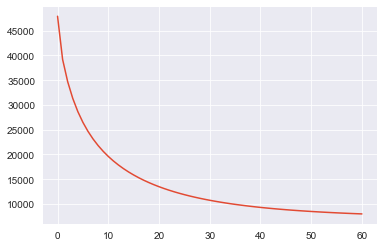

経過時間(実績)　= 0:03:01.434221 9902 / 10000 (99.01%)

score =  0.03425114517478048
lambda_p = 0.049999999999999996, alpha = 0.001, r_purchase = 0.06309573444801933
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:40.000766 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:13.322551 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:26.664095 5000002 / 5057824 (98.86%)

47830.56837099956
======= t =  1 =========
update P
経過時間(実績)　= 0:01:39.832791 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:13.620563 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:26.778715 5000002 / 5057824 (98.86%)

39131.59263040488
======= t =  2 =========
update P
経過時間(実績)　= 0:01:41.505877 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:14.030570 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:26.756678 5000002 / 5057824 (98.86%)

34647.931510543865
======= t =  3 =========
update P
経過時間(実績)　= 0:01:39.916306 980002 / 99000

経過時間(実績)　= 0:01:46.399628 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:19.088574 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:27.612407 5000002 / 5057824 (98.86%)

10064.57687603536
======= t =  35 =========
update P
経過時間(実績)　= 0:01:47.494510 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:18.556438 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:27.657490 5000002 / 5057824 (98.86%)

9918.884867380002
======= t =  36 =========
update P
経過時間(実績)　= 0:01:46.420678 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:18.823000 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:27.290954 5000002 / 5057824 (98.86%)

9781.584602265799
======= t =  37 =========
update P
経過時間(実績)　= 0:01:47.408392 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:11.974746 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:22.287252 5000002 / 5057824 (98.86%)

9652.099578125417
======= t =  38 =========
update P
経過時間(実績)　= 0:01:35.538233 980002 / 990000 (98.99%)

update Q
経過時間(実績

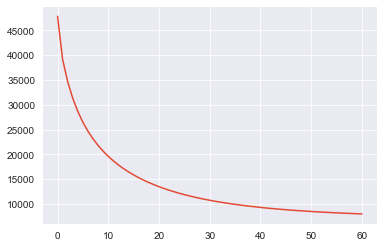

経過時間(実績)　= 0:03:11.244044 9902 / 10000 (99.01%)

score =  0.03597963970260852
lambda_p = 0.049999999999999996, alpha = 0.001, r_purchase = 0.3981071705534973
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:02:13.704824 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:17.066848 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:27.194121 5000002 / 5057824 (98.86%)

47827.353866270874
======= t =  1 =========
update P
経過時間(実績)　= 0:01:38.266592 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:13.048103 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.937895 5000002 / 5057824 (98.86%)

39122.52313691433
======= t =  2 =========
update P
経過時間(実績)　= 0:01:37.503459 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:16.918870 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.974210 5000002 / 5057824 (98.86%)

34641.87820579997
======= t =  3 =========
update P
経過時間(実績)　= 0:01:40.141789 980002 / 990000

経過時間(実績)　= 0:01:38.424844 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:16.501824 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:26.350347 5000002 / 5057824 (98.86%)

10038.115361102811
======= t =  35 =========
update P
経過時間(実績)　= 0:01:40.339806 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:47.187706 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:29.758079 5000002 / 5057824 (98.86%)

9892.782117108112
======= t =  36 =========
update P
経過時間(実績)　= 0:02:02.349253 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:31.684884 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:29.710460 5000002 / 5057824 (98.86%)

9755.848719563433
======= t =  37 =========
update P
経過時間(実績)　= 0:02:01.936631 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:21.775664 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:30.909155 5000002 / 5057824 (98.86%)

9626.737585357163
======= t =  38 =========
update P
経過時間(実績)　= 0:01:48.841679 980002 / 990000 (98.99%)

update Q
経過時間(実

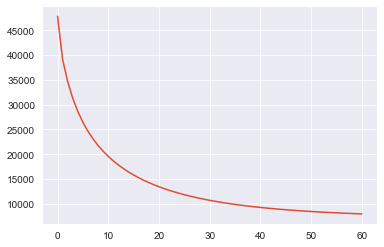

経過時間(実績)　= 0:03:12.693994 9902 / 10000 (99.01%)

score =  0.034998048564069704
lambda_p = 0.049999999999999996, alpha = 0.001, r_purchase = 2.5118864315095824
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:39.832798 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:17.428569 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:26.212375 5000002 / 5057824 (98.86%)

47835.30272346442
======= t =  1 =========
update P
経過時間(実績)　= 0:01:41.002103 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:16.948723 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:26.084264 5000002 / 5057824 (98.86%)

39131.80295783079
======= t =  2 =========
update P
経過時間(実績)　= 0:01:40.069530 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:16.298724 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:26.320537 5000002 / 5057824 (98.86%)

34651.407990642925
======= t =  3 =========
update P
経過時間(実績)　= 0:01:40.558563 980002 / 99000

経過時間(実績)　= 0:01:35.637717 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:09.505813 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.074065 5000002 / 5057824 (98.86%)

10065.882467356943
======= t =  35 =========
update P
経過時間(実績)　= 0:01:33.578464 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:08.986192 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.499337 5000002 / 5057824 (98.86%)

9919.425422683846
======= t =  36 =========
update P
経過時間(実績)　= 0:01:33.128043 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:08.657604 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.729711 5000002 / 5057824 (98.86%)

9781.385633266833
======= t =  37 =========
update P
経過時間(実績)　= 0:01:33.019580 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:00.257162 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:22.686239 5000002 / 5057824 (98.86%)

9651.185324685035
======= t =  38 =========
update P
経過時間(実績)　= 0:01:37.132721 980002 / 990000 (98.99%)

update Q
経過時間(実

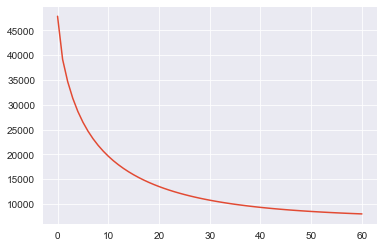

経過時間(実績)　= 0:03:09.271547 9902 / 10000 (99.01%)

score =  0.03512902641081408
lambda_p = 0.049999999999999996, alpha = 0.001, r_purchase = 15.848931924611142
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:41.255550 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:15.887938 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:26.405636 5000002 / 5057824 (98.86%)

47928.853182086365
======= t =  1 =========
update P
経過時間(実績)　= 0:01:39.361473 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:16.955934 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.757579 5000002 / 5057824 (98.86%)

39235.27838566536
======= t =  2 =========
update P
経過時間(実績)　= 0:01:37.760072 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:16.113939 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.795182 5000002 / 5057824 (98.86%)

34768.94334223535
======= t =  3 =========
update P
経過時間(実績)　= 0:01:38.349182 980002 / 990000

経過時間(実績)　= 0:01:35.955744 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:13.906990 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.501154 5000002 / 5057824 (98.86%)

10136.764612528934
======= t =  35 =========
update P
経過時間(実績)　= 0:01:41.538166 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:14.562936 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.316105 5000002 / 5057824 (98.86%)

9989.078208522078
======= t =  36 =========
update P
経過時間(実績)　= 0:01:34.765529 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:14.190096 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.542222 5000002 / 5057824 (98.86%)

9849.818087117505
======= t =  37 =========
update P
経過時間(実績)　= 0:01:35.748034 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:17.141481 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:26.029346 5000002 / 5057824 (98.86%)

9718.407835313054
======= t =  38 =========
update P
経過時間(実績)　= 0:01:35.060769 980002 / 990000 (98.99%)

update Q
経過時間(実

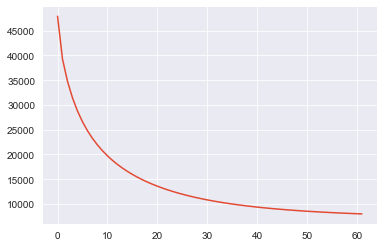

経過時間(実績)　= 0:03:00.690343 9902 / 10000 (99.01%)

score =  0.03574407078484427
lambda_p = 0.049999999999999996, alpha = 0.001, r_purchase = 100.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:34.085243 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:12.966038 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.823779 5000002 / 5057824 (98.86%)

48045.72156481525
======= t =  1 =========
update P
経過時間(実績)　= 0:01:33.440213 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:12.576748 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.774769 5000002 / 5057824 (98.86%)

39532.44447005403
======= t =  2 =========
update P
経過時間(実績)　= 0:01:33.047095 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:13.111540 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.894570 5000002 / 5057824 (98.86%)

35126.33591287638
======= t =  3 =========
update P
経過時間(実績)　= 0:01:33.070343 980002 / 990000 (98.99%)

upd

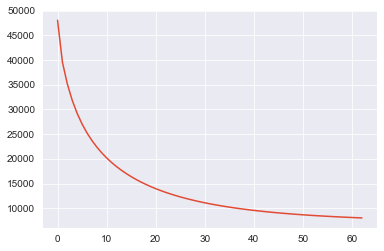

経過時間(実績)　= 0:03:09.119067 9902 / 10000 (99.01%)

score =  0.03413152500913178
lambda_p = 0.049999999999999996, alpha = 0.01, r_purchase = 0.01
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:38.203954 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:15.934571 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:26.466285 5000002 / 5057824 (98.86%)

47858.86187163211
======= t =  1 =========
update P
経過時間(実績)　= 0:01:37.546372 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:14.878393 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.541776 5000002 / 5057824 (98.86%)

39159.94333141517
======= t =  2 =========
update P
経過時間(実績)　= 0:01:35.828225 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:14.251899 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.831729 5000002 / 5057824 (98.86%)

34687.65618085668
======= t =  3 =========
update P
経過時間(実績)　= 0:01:38.772175 980002 / 990000 (98.99%)

updat

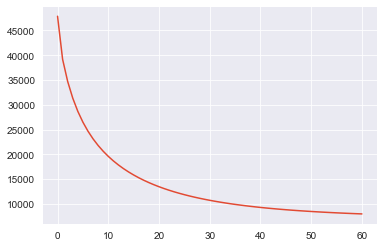

経過時間(実績)　= 0:02:43.219675 9902 / 10000 (99.01%)

score =  0.03533080698831227
lambda_p = 0.049999999999999996, alpha = 0.01, r_purchase = 0.06309573444801933
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:27.779527 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:04.673289 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.388475 5000002 / 5057824 (98.86%)

47908.07788034393
======= t =  1 =========
update P
経過時間(実績)　= 0:01:27.099336 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:04.933361 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.917591 5000002 / 5057824 (98.86%)

39199.63283987651
======= t =  2 =========
update P
経過時間(実績)　= 0:01:29.154732 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:04.894045 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.200832 5000002 / 5057824 (98.86%)

34720.442763417006
======= t =  3 =========
update P
経過時間(実績)　= 0:01:27.646929 980002 / 990000

経過時間(実績)　= 0:01:37.661276 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:14.125662 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.246604 5000002 / 5057824 (98.86%)

10086.875476823157
======= t =  35 =========
update P
経過時間(実績)　= 0:01:35.713613 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:15.410629 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.044415 5000002 / 5057824 (98.86%)

9940.829734094466
======= t =  36 =========
update P
経過時間(実績)　= 0:01:36.227841 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:14.391032 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.659896 5000002 / 5057824 (98.86%)

9803.145090986569
======= t =  37 =========
update P
経過時間(実績)　= 0:01:35.426256 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:14.772700 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.098275 5000002 / 5057824 (98.86%)

9673.24753137458
======= t =  38 =========
update P
経過時間(実績)　= 0:01:35.445007 980002 / 990000 (98.99%)

update Q
経過時間(実績

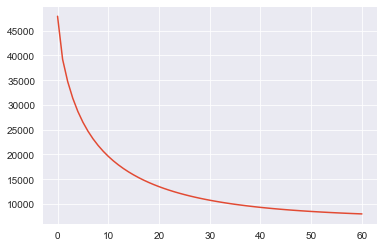

経過時間(実績)　= 0:03:08.426943 9902 / 10000 (99.01%)

score =  0.03639934355048911
lambda_p = 0.049999999999999996, alpha = 0.01, r_purchase = 0.3981071705534973
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:36.110427 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:14.967658 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.870425 5000002 / 5057824 (98.86%)

47876.100259165156
======= t =  1 =========
update P
経過時間(実績)　= 0:01:35.763545 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:14.278894 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:26.254124 5000002 / 5057824 (98.86%)

39195.1452578371
======= t =  2 =========
update P
経過時間(実績)　= 0:01:34.918616 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:14.586894 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.686058 5000002 / 5057824 (98.86%)

34736.328127802655
======= t =  3 =========
update P
経過時間(実績)　= 0:01:35.803235 980002 / 990000 

経過時間(実績)　= 0:01:32.795425 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:12.960308 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.796670 5000002 / 5057824 (98.86%)

10110.338117574738
======= t =  35 =========
update P
経過時間(実績)　= 0:01:33.731245 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:12.943290 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.715561 5000002 / 5057824 (98.86%)

9963.182457973606
======= t =  36 =========
update P
経過時間(実績)　= 0:01:33.267045 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:12.753081 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.836940 5000002 / 5057824 (98.86%)

9824.462437603814
======= t =  37 =========
update P
経過時間(実績)　= 0:01:33.050207 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:13.198779 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.700126 5000002 / 5057824 (98.86%)

9693.600141210503
======= t =  38 =========
update P
経過時間(実績)　= 0:01:32.552134 980002 / 990000 (98.99%)

update Q
経過時間(実

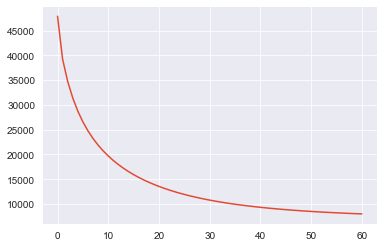

経過時間(実績)　= 0:03:09.786811 9902 / 10000 (99.01%)

score =  0.03455868197046833
lambda_p = 0.049999999999999996, alpha = 0.01, r_purchase = 2.5118864315095824
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:40.798831 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:16.811716 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:26.518607 5000002 / 5057824 (98.86%)

47899.895450628515
======= t =  1 =========
update P
経過時間(実績)　= 0:01:36.827172 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:16.460216 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:26.065291 5000002 / 5057824 (98.86%)

39205.51500130876
======= t =  2 =========
update P
経過時間(実績)　= 0:01:37.123769 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:18.441428 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:26.905987 5000002 / 5057824 (98.86%)

34705.865798573555
======= t =  3 =========
update P
経過時間(実績)　= 0:01:36.830444 980002 / 990000

経過時間(実績)　= 0:01:29.274266 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:09.113451 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.904484 5000002 / 5057824 (98.86%)

10128.288519745818
======= t =  35 =========
update P
経過時間(実績)　= 0:01:28.581248 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:08.980040 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.849705 5000002 / 5057824 (98.86%)

9981.105346275575
======= t =  36 =========
update P
経過時間(実績)　= 0:01:28.711362 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:09.444947 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.055925 5000002 / 5057824 (98.86%)

9842.318948439011
======= t =  37 =========
update P
経過時間(実績)　= 0:01:28.439795 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:09.236470 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.366552 5000002 / 5057824 (98.86%)

9711.356027965938
======= t =  38 =========
update P
経過時間(実績)　= 0:01:28.715640 980002 / 990000 (98.99%)

update Q
経過時間(実

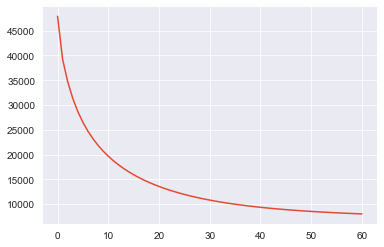

経過時間(実績)　= 0:02:45.498275 9902 / 10000 (99.01%)

score =  0.03602863179418082
lambda_p = 0.049999999999999996, alpha = 0.01, r_purchase = 15.848931924611142
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:24.990096 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:04.979384 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.436853 5000002 / 5057824 (98.86%)

48164.96108080162
======= t =  1 =========
update P
経過時間(実績)　= 0:01:24.196732 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.040812 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.249558 5000002 / 5057824 (98.86%)

39767.01263870026
======= t =  2 =========
update P
経過時間(実績)　= 0:01:22.739171 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.322781 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.740044 5000002 / 5057824 (98.86%)

35415.99109022828
======= t =  3 =========
update P
経過時間(実績)　= 0:01:23.223182 980002 / 990000 (

経過時間(実績)　= 0:01:21.744287 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:03.948587 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.294537 5000002 / 5057824 (98.86%)

10594.737578921066
======= t =  35 =========
update P
経過時間(実績)　= 0:01:22.066154 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:04.351864 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:22.765085 5000002 / 5057824 (98.86%)

10433.467075707318
======= t =  36 =========
update P
経過時間(実績)　= 0:01:21.597657 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:03.914168 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.209470 5000002 / 5057824 (98.86%)

10280.988539547197
======= t =  37 =========
update P
経過時間(実績)　= 0:01:22.294787 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:04.235299 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.024733 5000002 / 5057824 (98.86%)

10136.72477651839
======= t =  38 =========
update P
経過時間(実績)　= 0:01:21.459832 980002 / 990000 (98.99%)

update Q
経過時間

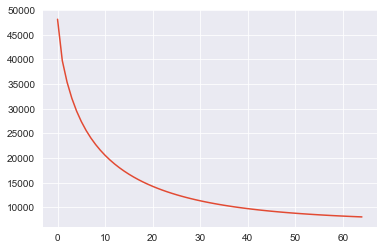

経過時間(実績)　= 0:02:38.478923 9902 / 10000 (99.01%)

score =  0.033586041528471625
lambda_p = 0.049999999999999996, alpha = 0.01, r_purchase = 100.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:19.310286 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:02.575683 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:22.782006 5000002 / 5057824 (98.86%)

48897.883573182036
======= t =  1 =========
update P
経過時間(実績)　= 0:01:19.351442 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:02.182609 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:22.906856 5000002 / 5057824 (98.86%)

41772.20606353664
======= t =  2 =========
update P
経過時間(実績)　= 0:01:20.186097 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:02.511868 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:22.455171 5000002 / 5057824 (98.86%)

37955.99544999356
======= t =  3 =========
update P
経過時間(実績)　= 0:01:18.982809 980002 / 990000 (98.99%)

up

経過時間(実績)　= 0:01:55.842980 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:11.506262 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.139475 5000002 / 5057824 (98.86%)

9169.630403451263
======= t =  70 =========
update P
経過時間(実績)　= 0:01:18.269083 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:00:57.160581 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.246841 5000002 / 5057824 (98.86%)

9111.522087346306
======= t =  71 =========
update P
経過時間(実績)　= 0:01:18.787830 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:00:57.398155 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.045437 5000002 / 5057824 (98.86%)

9055.291115225524
======= t =  72 =========
update P
経過時間(実績)　= 0:01:16.523640 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:00:56.455411 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:22.779945 5000002 / 5057824 (98.86%)

9000.865666438385
======= t =  73 =========
update P
経過時間(実績)　= 0:01:16.477204 980002 / 990000 (98.99%)

update Q
経過時間(実績

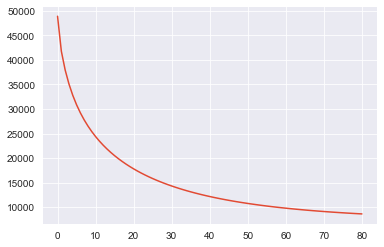

経過時間(実績)　= 0:02:24.028629 9902 / 10000 (99.01%)

score =  0.03009616688432215
lambda_p = 0.049999999999999996, alpha = 0.1, r_purchase = 0.01
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:15.976370 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:00:55.591359 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:22.780102 5000002 / 5057824 (98.86%)

47923.83549047684
======= t =  1 =========
update P
経過時間(実績)　= 0:01:15.888600 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:00:55.968869 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:22.244251 5000002 / 5057824 (98.86%)

39261.90469859066
======= t =  2 =========
update P
経過時間(実績)　= 0:01:18.208682 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:00:55.797774 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:22.152687 5000002 / 5057824 (98.86%)

34812.093058041515
======= t =  3 =========
update P
経過時間(実績)　= 0:01:15.597729 980002 / 990000 (98.99%)

updat

KeyboardInterrupt: 

In [67]:
num_iteration = 100
threshold_break = 0.005 # lossの改善が0.5%以下になったらbreak
k_dim = 100

model = matrix_factorization(df_R_train, df_item_features, k_dim, alpha = alpha_start, r_purchase = r_purchase_start, \
                             lambda_p = lambda_p_start, lambda_q = lambda_p_start)

# path_data_temp = r'C:\Users\yota-\Desktop\study\mystudy\recsys\dressipi_recsys2022\data\temp'
# model.df_P = pd.read_pickle(path_data_temp + r'\df_P_IMF_k' + str(k_dim) + r'.pkl')
# model.df_Q = pd.read_pickle(path_data_temp + r'\df_Q_IMF_k' + str(k_dim) + r'.pkl')
# model.df_P = df_P_rec
# model.df_Q = df_Q_rec
# model.update(10, threshold_break)

score_list_list = []

df_score = pd.DataFrame(columns = ["lambda_p", "alpha", "r_purchase", "score"])
idx_param = 0

num_session = len(model.session_id_list)
num_item = len(model.item_id_list)

for lambda_p in lambda_p_list:
    for alpha in alpha_list:
        for r_purchase in r_purchase_list:
            print("lambda_p = {:0}, alpha = {:1}, r_purchase = {:2}".format(lambda_p, alpha, r_purchase))
            model.reset_params(alpha, r_purchase, lambda_p = lambda_p, lambda_q = lambda_p)
            model.df_P = pd.DataFrame(np.random.randn(k_dim, num_session), columns = model.session_id_list, index = model.feature_name_list)
            model.df_Q = pd.DataFrame(np.random.randn(k_dim, num_item), columns = model.item_id_list, index = model.feature_name_list)

            loss_list = model.update(num_iteration, threshold_break)
            if len(loss_list) > 1:
                plt.plot(range(len(loss_list)), loss_list)
                plt.show()

            # スコアの算出
            df_y_pred = model.predict_items(df_X_valid, df_candidate_items)
            score = mean_reciprocal_rank(df_y_valid, df_y_pred)
            
            df_score.loc[idx_param] = [lambda_p, alpha, r_purchase, score]
            print("score = ", score)
            idx_param += 1

In [68]:
df_score

,lambda_p,alpha,r_purchase,score
0,0.05,0.001,0.010000,0.034251
1,0.05,0.001,0.063096,0.035980
2,0.05,0.001,0.398107,0.034998
3,0.05,0.001,2.511886,0.035129
4,0.05,0.001,15.848932,0.035744
5,0.05,0.001,100.000000,0.034132
6,0.05,0.010,0.010000,0.035331
7,0.05,0.010,0.063096,0.036399
8,0.05,0.010,0.398107,0.034559
9,0.05,0.010,2.511886,0.036029


0.049999999999999996


<AxesSubplot:title={'center':'$\\lambda_p$ = 0.049999999999999996'}, xlabel='r_purchase', ylabel='alpha'>

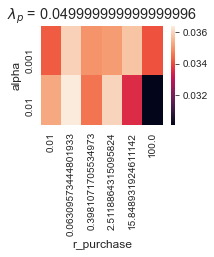

In [69]:
idx = 0
lambda_p = lambda_p_list[0]
plt.subplot(2, 2, idx + 1)
print(lambda_p)
plt.title("$\lambda_p$ = {:}".format(lambda_p))
sns.heatmap(df_score[df_score["lambda_p"] == lambda_p].pivot(index = "alpha", columns = "r_purchase", values = "score"), )